# Presets

In [1]:
sys.path.append('/home/spike/spike')

## Imports

In [2]:
from burst.utils import save_figure, save_as_pdf, get_size, runtime
from burst.io import get_probe, get_raw, get_events, get_pzo_events, resample_events, get_epochs
from burst.ecog import get_av, get_amplitudes, interpolate, plot_region
import ipywidgets as widgets
from ipywidgets import interactive, fixed, VBox, HBox
# from burst.plot import plot_map, plot_frames, plot_contour
import pickle
import IPython

## Path

To connect the PC on setup: 

`sudo mount -t cifs //R_KHZPV_7322/CheetahData3 /home/spike/mounts/R_KHZPV_7322/CheetahData3 -o user,rw`

## Probe

In [4]:
boards = interactive(get_probe, 
                     boards = widgets.Dropdown(options=['IB1_IB2', 'IB2_IB3', 'IB3_IB4', 'IB1_IB3'], value='IB2_IB3'),
                     plot=fixed(True))
display(boards)
plt.xticks(ticks=np.linspace(0, 3600, 10), labels=[str(x) for x in range(1,11)]);
plt.yticks(ticks=np.linspace(2000, 0, 6), labels=['A', 'B', 'C', 'D', 'E', 'F']);

interactive(children=(Dropdown(description='boards', index=1, options=('IB1_IB2', 'IB2_IB3', 'IB3_IB4', 'IB1_I…

In [5]:
df_probe, film_ch = boards.result

## Functions

In [6]:
def get_av(epochs, target_epoch='all', reref=True, baseline=True):
    
    #Reordering of channels according to the probe's topography
    
    
    #Signal preporcessing
    if reref:
        epochs = epochs.copy().set_eeg_reference()
    if baseline:
        epochs = epochs.copy().apply_baseline()
    
    if target_epoch == 'all':
        pass
    else:
        epochs = epochs.drop(np.delete(np.arange(f_epochs.get_data().shape[0]), int(target_epoch)))
        
    #Averaging:    
    av = epochs.copy().average()
    
    return av, f'_rrf:{reref}_bln:{baseline}_'

In [ ]:
# av, p = get_av(f_epochs, reref=True, baseline=True)
# ymin = av.data.T.min()     
# ymax = av.data.T.max()
# y = np.round(np.max([np.abs(ymin), np.abs(ymax)]))
# amplitudes, tmin = get_amplitudes(av, tmin=0.055, dt=0.001, statistics='mean')
# new_amplitudes = interpolate(amplitudes, method='cubic')


# fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,10]})
# fig.set_size_inches(7,7)
# plot_av(fig, av, tmin=0.025, dt=0.01, y=300)
# plot_map(fig, 
#          new_amplitudes, 
#          df_probe, 
#          target_chs=target_chs, 
#          noisy=[], 
#          y=y,
#          av=av,
#          show_channels=False,)

In [7]:
def plot_av(fig, av, tmin=0.025, dt=0.01, y=None, x=True):

    ymin = -y
    ymax = y
        
    ax = fig.axes[0]
    ax.clear()
    emin, emax = [np.round(av.times[0],1), np.round(av.times[-1],1)]
    times = np.linspace(emin, emax, av.data.T.shape[0])
    ax.plot(times, av.data.T , color='k', lw=0.1)
    start = int(0.5*av.info['sfreq'] + tmin*av.info['sfreq'])
    stop = start + int(dt*av.info['sfreq'])
    
    
    
    if x:
#         ymax = av.data[:,start:stop].max(axis=1)
#         ymin = -ymax
        ax.plot(times, av.data.T[:, np.argmax((av.data[:,start:stop]).max(axis=1))], color='k')
        ax.text(0,50, f'{av.ch_names[np.argmax((av.data[:,start:stop]).max(axis=1))]}')
        ax.set_xlim([0.0,0.1])
    else:
#         ymin = av.data[:,start:stop].min(axis=1)
#         ymax = -ymin
        ax.plot(times, av.data.T[:, np.argmin((av.data[:,start:stop]).min(axis=1))], color='k')
        ax.text(0,50, f'{av.ch_names[np.argmin((av.data[:,start:stop]).min(axis=1))]}')
        ax.set_xlim([-0.1,0.4])
        
    lines = np.linspace(0.0, 0.3, 61)
    ax.vlines(lines, ymin, ymax, color='r', lw=0.2)
    ax.set_yticks([ymin, 0, ymax])
    
    tmax = tmin + dt
    ax1.fill_between([tmin, tmax], ymin, ymax, color='r', alpha=0.4)

def plot_map(fig, 
             amplitudes, 
             df_probe, 
             target_chs=None, 
             noisy=None, 
             y=None,
             av=None,
            show_channels=False):
    
    ax = fig.axes[1]
    ax.clear()
    
     ##Show amplitudes
    plt.imshow(amplitudes, cmap='RdYlBu_r', vmin = -y, vmax=y)
    plt.contour(amplitudes, levels=np.arange(-y, y, y/10), colors='k', alpha=0.1)
    plt.gca().invert_yaxis() #invert it back, since it has been inverted by imshow()!
    plt.ylim([-200, 2200])
    plt.xlim([-200, 3800])
    plt.xticks(ticks=np.linspace(0, 3600, 10), labels=[str(x) for x in range(1,11)])
    plt.yticks(ticks=np.linspace(2000, 0, 6), labels=['A', 'B', 'C', 'D', 'E', 'F'])
    ax.xaxis.tick_top()
    
    H = 400 #constant hieght of the grid
    
    if show_channels:
        for i in df_probe.index:
            plt.text(df_probe.x[i], df_probe.y[i], df_probe.channel[i], ha='center', va='center')
    else:
        t1, t2 = int(av.data.shape[1]/3), int(av.data.shape[1]/3 + 2*av.data.shape[1]/15) #200
        for i in df_probe.index:
            time = np.linspace(df_probe.x[i] - 50, 
                               df_probe.x[i]+ 300 - 50, 
                               av.data[0,t1:t2].shape[0])
            sig = H*(av.data[i, t1:t2])/y  + df_probe.y[i] 
            ax.plot(time, sig, 'k', lw=1)
        
    x, y = np.mgrid[0:3601:400, 0:2001:400]
    plt.plot(x,y, '.r')
    
#     ax.spines.set_color('white')
    
    
    for ch in noisy:
        nx,ny = df_probe[df_probe['channel'] == ch].iloc[0,0:2].values
        plt.text(nx-20,ny-20, r"$\times$", 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=40, 
                 alpha=0.2)
            
        #linear probe location
    if target_chs:
        print('wow')
        df_target = df_probe[df_probe['channel'].isin(target_chs)]
        ax.plot(np.mean(df_target['x']), np.mean(df_target['y']), 'wx', ms=30, zorder=1)
#         lx,ly = linear_probe
#         plt.text(lx,ly, r"$\otimes$", 
#                  horizontalalignment='center', verticalalignment='center',
#                  color='white', 
#                  fontsize=40, 
#                  alpha=0.4)

def viewer(fig, 
           f_epochs, 
           df_probe, 
           reref=True, 
           baseline=True, 
           statistics='mean', 
           tmin=None, 
           dt=10, 
           noisy=None, 
           v='auto',
           x=True,
           show_channels=True,
           method='linear',
          target_chs=None,
          target_epoch='all'):
    
    if tmin != None:
        tmin *= 1e-3
        
    dt *= 1e-3
    
    av, p = get_av(f_epochs, target_epoch=target_epoch, reref=reref, baseline=baseline)
    
#     title = path[-20:-1] + p
    
    if v != 'auto':
        y = int(v)
    else:
        ymin = av.data.T.min()
        ymax = av.data.T.max()
        y = np.round(np.max([np.abs(ymin), np.abs(ymax)]))
    ymin = -y
    ymax = y
    
    amplitudes, tmin = get_amplitudes(av, tmin=tmin, dt=dt, statistics=statistics)
#     wtmin.value = tmin
    
    plot_av(fig, av=av, tmin=tmin, dt=dt, y=y, x=x)
    
    
    new_amplitudes = interpolate(amplitudes, method=method)
    
#     title += t
#     print(title)
    
    plot_map(fig, 
             new_amplitudes, 
             df_probe, 
             noisy=noisy, 
             y=y, 
             av=av, 
             show_channels=show_channels, 
             target_chs=target_chs)
    
    get_title()
    

In [ ]:
fig_map, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,10]})
fig_map.set_size_inches(7,7)

reref=True 
baseline=True
statistics='mean'
tmin=None
dt=10

noisy=None
v='auto'
x=True,
show_channels=True
method='linear'
target_chs=None
target_epoch='all'


if tmin != None:
    tmin *= 1e-3
        
dt *= 1e-3
    
av, p = get_av(f_epochs, target_epoch=target_epoch, reref=reref, baseline=baseline)
    
    
if v != 'auto':
    y = int(v)
else:
    ymin = av.data.T.min()
    ymax = av.data.T.max()
    y = np.round(np.max([np.abs(ymin), np.abs(ymax)]))
ymin = -y
ymax = y

amplitudes, tmin = get_amplitudes(av, tmin=tmin, dt=dt, statistics=statistics)


ymin = -y
ymax = y
    
ax = fig_map.axes[0]
ax.clear()
emin, emax = [np.round(av.times[0],1), np.round(av.times[-1],1)]
times = np.linspace(emin, emax, av.data.T.shape[0])
ax.plot(times, av.data.T , color='k', lw=0.1)
start = int(0.5*av.info['sfreq'] + tmin*av.info['sfreq'])
stop = start + int(dt*av.info['sfreq'])



# if x:
#     ymax = av.data[:,start:stop].max(axis=1)
#     ymin = -ymax
#     ax.plot(times, av.data.T[:, np.argmax((av.data[:,start:stop]).max(axis=1))], color='k')
#     ax.text(0,50, f'{av.ch_names[np.argmax((av.data[:,start:stop]).max(axis=1))]}')
#     ax.set_xlim([0.0,0.1])
# else:
#     ymin = av.data[:,start:stop].min(axis=1)
#     ymax = -ymin
#     ax.plot(times, av.data.T[:, np.argmin((av.data[:,start:stop]).min(axis=1))], color='k')
#     ax.text(0,50, f'{av.ch_names[np.argmin((av.data[:,start:stop]).min(axis=1))]}')
#     ax.set_xlim([-0.1,0.4])
    
lines = np.linspace(0.0, 0.3, 61)
ax.vlines(lines, ymin, ymax, color='r', lw=0.2)
ax.set_yticks([ymin, 0, ymax])

tmax = tmin + dt

new_amplitudes = interpolate(amplitudes, method='cubic')

In [ ]:
amplitudes.shape

In [ ]:
plt.figure()
plt.imshow(amplitudes.reshape(6,10))

In [ ]:
av.data.shape

In [ ]:
av.data[:,start:stop]

# Map

### Upload

In [13]:
def upload_epochs(rec):
    if rec == ' ':
        pass
    else:
        with open(f'/media/data/sINBOX/epochs/{rec}', 'rb') as f:
            epochs = pickle.load(f)
        return epochs

opt = os.listdir('/media/data/sINBOX/epochs/')
opt.sort()
ddrec = widgets.Dropdown(options=opt,
                        description='Rec:',
                        disabled=False)

wrec = widgets.interactive(upload_epochs, rec=ddrec)
display(wrec)

interactive(children=(Dropdown(description='Rec:', options=('2019-07-22_20-46-27_P10_BC_linear_only.pkl', '201…

In [14]:
try:
    del f_epochs
except:
    pass
print(len(wrec.result))
try:
    f_epochs, noisy, target_chs, a_epochs,p  = wrec.result
except:
    pass
try:
    f_epochs, noisy, target_chs, a_epochs = wrec.result
except:
    pass
try:
    f_epochs, noisy = wrec.result
    target_chs = []
except:
    pass
        
# f_epochs, noisy, a_epochs = wrec.result

2


In [10]:
(np.diff(f_epochs.events[:,0])/2000).size

19

<IPython.core.display.Javascript object>


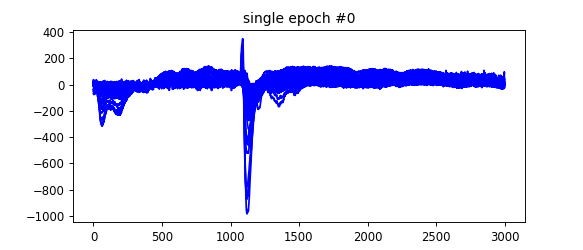

Text(0.5, 1.0, 'single epoch #0')

In [15]:
plt.figure()
e_id =0
plt.plot(f_epochs.get_data()[e_id,:,:].T, 'blue');
plt.title(f'single epoch #{e_id}')

In [ ]:
# from burst.ecog import get_rid_of_noisy
# get_rid_of_noisy(f_epochs, df_probe, ['CSC74'])

In [ ]:
np.arange(0,49,2)

In [ ]:
ids = np.arange(0,48,2)
f_epochs.drop(ids)

### Plot

<IPython.core.display.Javascript object>


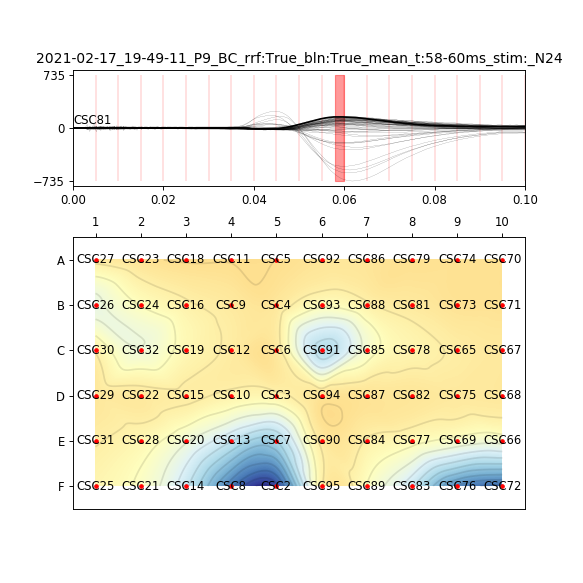

In [16]:
plt.ioff()
fig_map, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,10]})
fig_map.set_size_inches(7,7)
plt.ion()

import matplotlib
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


#Preprocessing box

wreref = widgets.Checkbox(value=True)

wbaseline = widgets.Checkbox(description='baseline', value=True)

wstatistics = widgets.Dropdown(options=['mean', 'min'])

pbox = widgets.HBox([wreref, wbaseline, wstatistics])

# wv = widgets.IntSlider(value=0,
#                           min=0,
#                           max=2000,
#                           step=10,
#                           continuous_update=False)
wv = widgets.Text(value='auto')
wx = widgets.Checkbox(description='P',
                      value=False,
                     layout=widgets.Layout(width = '200px'))


wshowchs = widgets.Checkbox(description='ch-s', 
                            value=False,
                           layout=widgets.Layout(width = '200px'))
wmethod = widgets.Dropdown(options=['linear', 'cubic'])

visbox = widgets.HBox([wshowchs, wx, wmethod, wv])



#Timebox

wauto = widgets.Button(description='auto', layout=widgets.Layout(width = '60px'))


def on_button_clicked(b):
    viewer(fig_map, f_epochs, 
           df_probe, 
           reref=wreref.value, 
           baseline=wbaseline.value, 
           statistics=wstatistics.value, 
           tmin=None, 
           dt=wdt.value, 
           noisy=noisy,
           v=wv.value,
           show_channels=wshowchs.value,
           method=wmethod.value,
           target_chs=target_chs
          )

wauto.on_click(on_button_clicked)

wplay = widgets.Play(
    value=5,
    min=0,
    max=300,
    step=1,
    interval=5000, #2000
    disabled=False
)
wtmin = widgets.IntSlider(value=0,
                          min=0,
                          max=300,
                          step=1,
                          continuous_update=False,
                          layout=widgets.Layout(width = '500px'))



widgets.jslink((wplay, 'value'), (wtmin, 'value'))

wdt = widgets.IntSlider(value=2,
                          min=0,
                          max=50,
                          step=1,
                          continuous_update=False,
                          readout_format='.0f')

tbox = widgets.HBox([wauto, wplay, wtmin, wdt])


#Save box

wstim = widgets.Dropdown(options=['','BC', 'eAC', 'AC', 'IC', 'CO', 'SS', 'VE', 'VIS'])

wcomment = widgets.Text()

wsave = widgets.Button(description='save')


def get_title():
    title = f'{wrec.children[0].value[:-4]}_\
rrf:{wreref.value}_bln:{wbaseline.value}_{wstatistics.value}_\
t:{wtmin.value}-{wtmin.value+wdt.value}ms_\
stim:{wstim.value}{wcomment.value}_N{f_epochs.get_data().shape[0]}'
    fig_map.axes[0].set_title(title)
    return title

def on_button_clicked(b):
    save_figure(fig_map, get_title(), pdf=wpdf.value)
#     save_as_pdf(fig, f'/media/data/sINBOX/{get_title()}.pdf')

wsave.on_click(on_button_clicked)

wpdf = widgets.Checkbox(description='pdf', value=False)

savebox = HBox([wstim, wcomment, wsave, wpdf])

wepoch = widgets.Text(value='all')
ebox = HBox([wepoch])


#Interactive

w = widgets.interactive(viewer, 
                fig=widgets.fixed(fig_map),        
                f_epochs=widgets.fixed(f_epochs),
                df_probe=widgets.fixed(df_probe),        
                reref=wreref,
                baseline=wbaseline,
                statistics=wstatistics,
                tmin=wplay, 
                dt=wdt,
                noisy=widgets.fixed(noisy),
                v=wv,
                x=wx,
                show_channels=wshowchs,
                method=wmethod,
                target_chs=widgets.fixed(target_chs),
                target_epoch=wepoch)

tab = widgets.Tab()
tab_contents = [pbox, tbox, ebox, visbox, savebox]
tab.children = tab_contents
tab.titles = ['Preprocessing', 'Time window', 'Visualization', 'Save']


display(tab)
fig_map
# plt.gcf()

In [ ]:
idx = np.where(np.array(av.ch_names)=='CSC35')[0][0]
idx

In [ ]:
plt.figure()
sig = f_epochs.set_eeg_reference().get_data()[:, idx, 1000:1400]
plt.plot(sig.mean(0), 'k')
# plt.plot(sig.mean(0) - scipy.stats.sem(sig), color='gray')
# plt.plot(sig.mean(0) + scipy.stats.sem(sig), color='gray')
plt.fill_between(np.arange(400), sig.mean(0) - scipy.stats.sem(sig), sig.mean(0) + scipy.stats.sem(sig), color='#d8d9da')

In [ ]:
plt.ylim(-1000, 500)

In [ ]:
save_figure(plt.gcf(), f'{get_title()}trace', pdf=True)

In [ ]:
tmin = 0.28
ts_min = int(tmin*2000 + 1000)
ts_min

In [ ]:
plt.figure()
av.data[24,ts_min:ts_min+100].mean()

In [ ]:
# noisy = ['CSC34', 'CSC47', 'CSC57']

In [ ]:
# rec = (f_epochs, noisy)
# # rec = (f_epochs, noisy, target_chs, a_epochs)
# filename = f'/media/data/sINBOX/epochs/{input("rec: ")}_{input("age: ")}_{input("stim.: ")}.pkl'
# with open(filename, 'wb') as f:
#     pickle.dump(rec, f)
# filename

In [ ]:
from burst.ecog import get_rid_of_noisy
get_rid_of_noisy(f_epochs, df_probe, ['CSC47', 'CSC74'])

### rename

In [ ]:
opt = os.listdir('/media/data/sINBOX/epochs/')
opt.sort()
file_name = opt[141]
file_name

In [ ]:
rec = input('rec: ')
age = input('age: ')
stim = input('stim: ')
comment = input('comment: ')
if comment == '':
    file_name_new = f'{rec}_{age}_{stim}.pkl'
else:
    file_name_new = f'{rec}_{age}_{stim}_{comment}.pkl'
file_name_new

In [ ]:
import os  
directory = '/media/data/sINBOX/epochs/'
if input(prompt=f'{directory + file_name}\n{directory + file_name_new}\n\ny/n? :') == 'y':
    os.rename(directory + file_name, directory + file_name_new) 

### Check

In [ ]:
df

In [ ]:
i = 10

In [ ]:
new_opt

In [ ]:
try:
    f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
except:
    pass
try:
    f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
except:
    pass
try:
    f_epochs, noisy = upload_epochs(new_opt[i])
    target_chs = []
except:
    pass

In [ ]:
dt = 0.002
av, p = get_av(f_epochs, reref=True, baseline=True)
    
    
tmin_P = 32
if tmin_P == '-':
    pass
else:
    tmin_P = (int(tmin_P) - 1)/1000
    
tmin_P

In [ ]:
av, p = get_av(f_epochs, reref=True, baseline=True)
amplitudes, tmin = get_amplitudes(av, tmin=wtmin.value/1000, dt=wdt.value/1000, statistics='mean')
new_amplitudes = interpolate(amplitudes, method='cubic')
print(wtmin.value/1000, wdt.value/1000)

In [ ]:
plt.figure()
plt.plot(av.data.T)

In [ ]:
m_bc_P = new_amplitudes > 0.5*new_amplitudes.max()

In [ ]:
plt.figure()
plt.imshow(m_bc_P)
plt.gca().invert_yaxis()

In [ ]:
        blob = np.argwhere(m_bc_P)
#         ax[0].plot(blob[:,1] - row['P x'], blob[:,0] - row['P y'], '.', color='#ff7f0e', alpha=0.1)
        mask_P = np.zeros((4000,4000))
    
        if row['stim'] == 'bc':
            cmap = 'Greys'
            plt.plot(2000, 2000, 'k+')
            
            bc_x, bc_y = row['P x'], row['P y']
        if row['stim'] == stim:
            cmap = 'Reds'
            plt.plot(2000 + row['P x'] - bc_x, 2000 + row['P y'] - bc_y, 'r+')
               
            
            
            
        mask_P[(blob[:,0] - row['P y'] + 2000).astype(int), (blob[:,1] - row['P x'] + 2000).astype(int)] = 1
        plt.contour(mask_P, cmap=cmap, alpha=0.1)

### PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=10)

In [ ]:
av, _ = get_av(f_epochs, reref=True, baseline=True)

In [ ]:
av.data.shape

In [ ]:
# av.reorder_channels(p.label.to_numpy())

In [ ]:
scores = pca.fit_transform(av.data)

In [ ]:
scores.shape

In [ ]:
fig_PCA, ax = plt.subplots(1,3)
fig_PCA.set_size_inches(9,3)
for i,s in enumerate(scores[:,:3].T):
    new_scores = interpolate(s, method='cubic')
    ax[i].imshow(new_scores)
    ax[i].invert_yaxis()
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
    
plt.suptitle(get_title()[:19] + ' PCA')
plt.tight_layout()

In [ ]:
p = IALDEV.Probe()

In [ ]:
p.list_probes()

In [ ]:
p.init_probe('A60_FILM_IB2_IB3.prb.csv')

In [ ]:
p.show_layout()

In [ ]:
p.topo_plot(scores[:,0], method='cubic', voxel=10)
p.topo_plot(scores[:,1], method='cubic', voxel=10)
p.topo_plot(scores[:,2], method='cubic', voxel=10)

In [ ]:
p.topo_plot(scores[:,0], method='cubic', voxel=10)
p.topo_plot(scores[:,1], method='cubic', voxel=10)
p.topo_plot(scores[:,2], method='cubic', voxel=10)

In [ ]:
plt.figure()
plt.plot(pca.components_.T - 0.1*np.arange(10))

In [ ]:
plt.figure()
plt.plot(pca.components_.T - 0.1*np.arange(10))

In [ ]:
plt.figure()
plt.plot(pca.explained_variance_ratio_)

In [ ]:
target = ['CSC84', 'CSC87', 'CSC82', 'CSC77']

In [ ]:
drop = []
for ch in f_epochs.ch_names:
    if ch not in target:
        drop.append(ch)

In [ ]:
f_epochs.set_eeg_reference().drop_channels(drop)

In [ ]:
plt.figure()
plt.plot(f_epochs.get_data().mean(axis=0).T)

In [ ]:
f_epochs.get_data().mean(axis=0).min(axis=1).mean()

In [ ]:
from burst.ecog import get_rid_of_noisy
get_rid_of_noisy(f_epochs, df_probe, ['CSC34'])

### Frames

In [ ]:
frames = np.hstack((np.linspace(0.0, 0.19, 39).reshape(-1,1), np.linspace(0.0, 0.19, 39).reshape(-1,1) + 0.005))
# np.round(frames, decimals=3)
frames[-2:,:]
# frames+= 0.1

In [ ]:
from burst.utils import mem_check
mem_check()
av, p = get_av(f_epochs, reref=True, baseline=True)
fig = plt.figure(figsize=[9,9])
ymin = av.data.T.min()
ymax = av.data.T.max()
y = np.round(np.max([np.abs(ymin), np.abs(ymax)]))
linear = None

for i, (tmin,tmax) in tqdm(enumerate(frames[:-4,:])):
    amplitudes, _ = get_amplitudes(av, tmin=tmin, dt=0.001, statistics='mean')
    new_amplitudes = interpolate(amplitudes, method='cubic')
    plt.subplot(7,5,i+1)
    plt.imshow(new_amplitudes, cmap='RdYlBu_r', vmin = -y, vmax=y)
    plt.contour(new_amplitudes, levels=np.arange(-y, y, y/10), colors='k', alpha=0.1)
    plt.gca().invert_yaxis() #invert it back, since it has been inverted by imshow()!
    plt.ylim([-200, 2200])
    plt.xlim([-200, 3800])
    plt.axis('off')
#     plt.title(f'{tmin:.3f}-{tmax:.3f}', fontsize=1)

    if linear:
        lx,ly = linear
        plt.gca().plot(lx,ly, 'k.')

    plt.title(f'{tmin*1e3:.0f}-{tmax*1e3:.0f} ms', fontsize=10)
    
    plt.tight_layout()
    
save_figure(fig, get_title() + 'frames', dpi=150)

mem_check()

IPython.display.Audio(filename="/media/data/sINBOX/ding-sound-effect_2.mp3", autoplay=True, rate=144)

In [ ]:
(0.04 - 0.01)/0.002

In [ ]:
frames = np.hstack((np.linspace(0.01, 0.048, 20).reshape(-1,1), np.linspace(0.01, 0.048, 20).reshape(-1,1) + 0.002))
# np.round(frames, decimals=3)
print(frames[:2,:])
print('...')
print(frames[-2:,:])
# frames+= 0.1

In [ ]:
from burst.utils import mem_check
mem_check()
av, p = get_av(f_epochs, reref=True, baseline=True)
fig = plt.figure(figsize=[9,5])
ymin = av.data.T.min()
ymax = av.data.T.max()
y = np.round(np.max([np.abs(ymin), np.abs(ymax)]))
linear = None
y = 100


for i, (tmin,tmax) in tqdm(enumerate(frames[:,:])):
    amplitudes, _ = get_amplitudes(av, tmin=tmin, dt=0.002, statistics='mean')
    new_amplitudes = interpolate(amplitudes, method='cubic')
    plt.subplot(4,5,i+1)
    plt.imshow(new_amplitudes, cmap='RdYlBu_r', vmin = -y, vmax=y)
    plt.contour(new_amplitudes, levels=np.arange(-y, y, y/10), colors='k', alpha=0.1)
    plt.gca().invert_yaxis() #invert it back, since it has been inverted by imshow()!
    plt.ylim([-200, 2200])
    plt.xlim([-200, 3800])
    plt.axis('off')
#     plt.title(f'{tmin:.3f}-{tmax:.3f}', fontsize=1)

    if linear:
        lx,ly = linear
        plt.gca().plot(lx,ly, 'k.')

    plt.title(f'{tmin*1e3:.0f}-{tmax*1e3:.0f} ms', fontsize=10)
    
    plt.tight_layout()
    
save_figure(fig, get_title() + 'frames', dpi=150)

mem_check()

IPython.display.Audio(filename="/media/data/sINBOX/ding-sound-effect_2.mp3", autoplay=True, rate=144)

In [ ]:
save_figure(fig, get_title() + 'frames', dpi=150)

### Contours

In [ ]:
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.array(np.where(detected_minima))

In [ ]:
def merge_points(original, idx):
    print(idx)
    print(original)
    if original.shape[1] > 1:
        if (np.diff(original[:,idx:idx+2]) > 0).mean(0).astype("bool")[0]:

            if idx+2 < original.shape[1]:

                new_points= merge_points(original, idx+1)
            else:
                new_points = original
        else:

            mean = original[:,idx:idx+2].mean(axis=1)
            new_points = np.delete(original, [idx, idx+1], axis=1)
            new_points = np.hstack((new_points[:,:idx], mean.reshape(2,1), new_points[:,idx:]))
            new_points = merge_points(new_points, idx=0)
    else:
        new_points = original
    return new_points

In [ ]:
wpositive = widgets.Checkbox(description='positive', value=True)
display(wpositive)

In [ ]:
av, p = get_av(f_epochs, reref=True, baseline=True)
ymin = av.data.T.min()     
ymax = av.data.T.max()
y = np.round(np.max([np.abs(ymin), np.abs(ymax)]))
amplitudes, tmin = get_amplitudes(av, tmin=wtmin.value/1000, dt=wdt.value/1000, statistics='mean')
new_amplitudes = interpolate(amplitudes, method='cubic')
print(wtmin.value/1000)

In [ ]:
positive = wpositive.value
if positive:
    new_amplitudes = -new_amplitudes
    colormap = 'RdYlBu_r'
else:
    colormap = 'RdYlBu'

In [ ]:
##for ic only
# filename = f'/media/data/sINBOX/av/{get_title()}_av.pkl'
# with open(filename, 'wb') as f:
#     pickle.dump(av, f)
# filename

In [ ]:
# amplitudes = av.copy().crop(0.02, 0.1).data.mean(1)

In [ ]:
negative_amplitudes = new_amplitudes.copy()

In [ ]:
# negative_amplitudes[negative_amplitudes > negative_amplitudes.min()/2] = 0
negative_amplitudes[negative_amplitudes > -350] = 0

In [ ]:
f = plt.figure()
plt.imshow(negative_amplitudes, cmap='binary_r')
plt.gca().invert_yaxis()

In [ ]:
# local_minima = detect_local_minima(negative_amplitudes)
# new_minima = local_minima
# for py,px in new_minima.T:
#     print(px, py)
#     mask[py, px] = 1

In [ ]:
mask = np.zeros_like(negative_amplitudes)
local_minima = detect_local_minima(negative_amplitudes)

drop = []
for i, (py,px) in enumerate(local_minima.T):
#     print(f'x {px}, y {py}')
    if ((py > -1) & (py < 2000)) & ((px > -1) & (px < 3600)):
        pass
    else:
        drop.append(i)
local_minima = np.delete(local_minima, drop, axis=1)

if local_minima.shape[1] > 1:
    new_minima = merge_points(local_minima, 0).astype(int)
else:
    new_minima = local_minima

print('\nlocal minima')    
max_amp = 0
for py,px in new_minima.T:
    print(f'amp:{-np.round(new_amplitudes[py, px],2)} ... x,y : {px}, {py}')
    if max_amp < abs(-np.round(new_amplitudes[py, px],2)):
        max_amp = abs(-np.round(new_amplitudes[py, px],2))
        max_x, max_y = px,py
    mask[py, px] = 1

In [ ]:
new_amplitudes[py, px]/2

In [ ]:
plt.figure()
c = ['r', 'g', 'b']
for i, (py,px) in enumerate(new_minima.T):
    print(px, py)
    plt.plot(px, py, 'o', color=c[i])
    plt.contour(new_amplitudes, levels=[new_amplitudes[py, px]*0.5], colors=c[i])

plt.xlim([0, 3600])
plt.ylim([0,2000])

In [ ]:
save_figure(plt.gcf(), 'contour bc', pdf=True)

In [ ]:
fig_amp = plt.figure(figsize=[9,5])


plt.imshow(-negative_amplitudes, cmap=colormap, vmin=-y, vmax=y)
plt.contour(new_amplitudes, levels=np.arange(-y, y, y/10), colors='k', alpha=0.1)
# plt.colorbar()

# mask = (new_amplitudes < new_amplitudes.min()/2).astype(int)
plt.imshow(mask, cmap='gray', alpha=0.3)
# plt.colorbar()

plt.gca().invert_yaxis()


plt.plot(new_minima[1], new_minima[0], 'xr', ms=50, alpha=0.5)
plt.plot(local_minima[1], local_minima[0], '.w', ms=5)

plt.title(f'{get_title()[:19]} tmin:{int(tmin*1000)}ms, dt:{wdt.value}ms, x:{max_x}, y:{max_y}')

save_figure(fig_amp, get_title() + 'minima', dpi=150)

In [ ]:
new_amplitudes.max(), np.abs(new_amplitudes.min())

In [ ]:
new_amplitudes.max()*np.array([0.25,0.5,0.75, 0.95])

### Intersection

In [ ]:
av, p = get_av(f_epochs, reref=True, baseline=True)
amplitudes, tmin = get_amplitudes(av, tmin=wtmin.value/1000, dt=wdt.value/1000, statistics='mean')
new_amplitudes = interpolate(amplitudes, method='cubic')
print(wtmin.value/1000)

#### P

In [ ]:
m1bcP = new_amplitudes > 0.75*new_amplitudes.max()
m2bcP = new_amplitudes > 0.5*new_amplitudes.max()
m3bcP = new_amplitudes > 0.25*new_amplitudes.max()

fig_m = plt.figure()
plt.imshow(m1bcP, cmap='binary', alpha=0.1)
plt.imshow(m2bcP, cmap='binary', alpha=0.1)
plt.imshow(m3bcP, cmap='binary', alpha=0.1)
plt.gca().invert_yaxis()

In [ ]:
m1P = new_amplitudes > 0.75*new_amplitudes.max()
m2P = new_amplitudes > 0.5*new_amplitudes.max()
m3P = new_amplitudes > 0.25*new_amplitudes.max()

plt.figure()
plt.imshow(m1P, cmap='binary', alpha=0.1)
plt.imshow(m2P, cmap='binary', alpha=0.1)
plt.imshow(m3P, cmap='binary', alpha=0.1)
plt.gca().invert_yaxis()

In [ ]:
m1bc,m2bc,m3bc = m1bcP,m2bcP,m3bcP
m1,m2,m3 = m1P,m2P,m3P


fig_iou, (ax1, ax2, ax3) = plt.subplots(1,3)
fig_iou.set_size_inches(9.5,3)

ax1.imshow(m1bc, cmap='Greys', alpha=0.5)
ax2.imshow(m2bc, cmap='Greys', alpha=0.5)
ax3.imshow(m3bc, cmap='Greys', alpha=0.5)


ax1.imshow(m1, cmap='Blues', alpha=0.5)
ax2.imshow(m2, cmap='Blues', alpha=0.5)
ax3.imshow(m3, cmap='Blues', alpha=0.5)


ax1.set_title(f'P25%: {np.round(np.count_nonzero(m1bc & m1)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m1bc & m1)/np.count_nonzero(m1bc | m1)), 2)}\n {np.round((np.count_nonzero(m1bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m1))*1e-6, 2)} mm2',)
ax2.set_title(f'P50%: {np.round(np.count_nonzero(m2bc & m2)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m2bc & m2)/np.count_nonzero(m2bc | m2)), 2)}\n {np.round((np.count_nonzero(m2bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m2))*1e-6, 2)} mm2', )
ax3.set_title(f'P75%: {np.round(np.count_nonzero(m3bc & m3)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m3bc & m3)/np.count_nonzero(m3bc | m3)), 2)}\n {np.round((np.count_nonzero(m3bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m3))*1e-6, 2)} mm2', )

print(f'{np.round(np.count_nonzero(m1bc & m1)*1e-6, 2)},{np.round(np.count_nonzero(m2bc & m2)*1e-6, 2)},{np.round(np.count_nonzero(m3bc & m3)*1e-6, 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1bc & m1)/np.count_nonzero(m1bc | m1)), 2)},{np.round((np.count_nonzero(m2bc & m2)/np.count_nonzero(m2bc | m2)), 2)},{np.round((np.count_nonzero(m3bc & m3)/np.count_nonzero(m3bc | m3)), 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1bc))*1e-6, 2)}, {np.round((np.count_nonzero(m2bc))*1e-6, 2)}, {np.round((np.count_nonzero(m3bc))*1e-6, 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1))*1e-6, 2)}, {np.round((np.count_nonzero(m2))*1e-6, 2)}, {np.round((np.count_nonzero(m3))*1e-6, 2)}')
print('   ')

plt.suptitle(get_title(), alpha=0.3)

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])


ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
plt.tight_layout()

save_figure(fig_iou, get_title() + 'IoU', dpi=150, pdf=False)

#### N

In [ ]:
m1bcN = new_amplitudes < 0.75*new_amplitudes.min()
m2bcN = new_amplitudes < 0.5*new_amplitudes.min()
m3bcN = new_amplitudes < 0.25*new_amplitudes.min()

fig_m = plt.figure()
plt.imshow(m1bcN, cmap='binary', alpha=0.1)
plt.imshow(m2bcN, cmap='binary', alpha=0.1)
plt.imshow(m3bcN, cmap='binary', alpha=0.1)
plt.gca().invert_yaxis()

In [ ]:
m1N = new_amplitudes < 0.75*new_amplitudes.min()
m2N = new_amplitudes < 0.5*new_amplitudes.min()
m3N = new_amplitudes < 0.25*new_amplitudes.min()

plt.figure()
plt.imshow(m1N, cmap='binary', alpha=0.1)
plt.imshow(m2N, cmap='binary', alpha=0.1)
plt.imshow(m3N, cmap='binary', alpha=0.1)
plt.gca().invert_yaxis()

In [ ]:
m1bc,m2bc,m3bc = m1bcN,m2bcN,m3bcN
m1,m2,m3 = m1N,m2N,m3N


fig_iou, (ax1, ax2, ax3) = plt.subplots(1,3)
fig_iou.set_size_inches(9.5,3)

ax1.imshow(m1bc, cmap='Greys', alpha=0.5)
ax2.imshow(m2bc, cmap='Greys', alpha=0.5)
ax3.imshow(m3bc, cmap='Greys', alpha=0.5)


ax1.imshow(m1, cmap='Blues', alpha=0.5)
ax2.imshow(m2, cmap='Blues', alpha=0.5)
ax3.imshow(m3, cmap='Blues', alpha=0.5)


ax1.set_title(f'N25%: {np.round(np.count_nonzero(m1bc & m1)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m1bc & m1)/np.count_nonzero(m1bc | m1)), 2)}\n {np.round((np.count_nonzero(m1bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m1))*1e-6, 2)} mm2',)
ax2.set_title(f'N50%: {np.round(np.count_nonzero(m2bc & m2)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m2bc & m2)/np.count_nonzero(m2bc | m2)), 2)}\n {np.round((np.count_nonzero(m2bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m2))*1e-6, 2)} mm2', )
ax3.set_title(f'N75%: {np.round(np.count_nonzero(m3bc & m3)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m3bc & m3)/np.count_nonzero(m3bc | m3)), 2)}\n {np.round((np.count_nonzero(m3bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m3))*1e-6, 2)} mm2', )

print(f'{np.round(np.count_nonzero(m1bc & m1)*1e-6, 2)},{np.round(np.count_nonzero(m2bc & m2)*1e-6, 2)},{np.round(np.count_nonzero(m3bc & m3)*1e-6, 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1bc & m1)/np.count_nonzero(m1bc | m1)), 2)},{np.round((np.count_nonzero(m2bc & m2)/np.count_nonzero(m2bc | m2)), 2)},{np.round((np.count_nonzero(m3bc & m3)/np.count_nonzero(m3bc | m3)), 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1bc))*1e-6, 2)}, {np.round((np.count_nonzero(m2bc))*1e-6, 2)}, {np.round((np.count_nonzero(m3bc))*1e-6, 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1))*1e-6, 2)}, {np.round((np.count_nonzero(m2))*1e-6, 2)}, {np.round((np.count_nonzero(m3))*1e-6, 2)}')
print('   ')

plt.suptitle(get_title(), alpha=0.3)

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])


ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
plt.tight_layout()

save_figure(fig_iou, get_title() + 'IoU', dpi=150, pdf=False)

#### IoU

In [ ]:
m1bc,m2bc,m3bc = m1bcP,m2bcP,m3bcP
m1,m2,m3 = m1bcN,m2bcN,m3bcN


fig_iou, (ax1, ax2, ax3) = plt.subplots(1,3)
fig_iou.set_size_inches(9.5,3)

ax1.imshow(m1bc, cmap='Reds', alpha=0.5)
ax2.imshow(m2bc, cmap='Reds', alpha=0.5)
ax3.imshow(m3bc, cmap='Reds', alpha=0.5)


ax1.imshow(m1, cmap='Blues', alpha=0.5)
ax2.imshow(m2, cmap='Blues', alpha=0.5)
ax3.imshow(m3, cmap='Blues', alpha=0.5)


ax1.set_title(f'bcPN25%: {np.round(np.count_nonzero(m1bc & m1)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m1bc & m1)/np.count_nonzero(m1bc | m1)), 2)}\n {np.round((np.count_nonzero(m1bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m1))*1e-6, 2)} mm2',)
ax2.set_title(f'bcPN50%: {np.round(np.count_nonzero(m2bc & m2)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m2bc & m2)/np.count_nonzero(m2bc | m2)), 2)}\n {np.round((np.count_nonzero(m2bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m2))*1e-6, 2)} mm2', )
ax3.set_title(f'bcPN75%: {np.round(np.count_nonzero(m3bc & m3)*1e-6, 2)} mm2, IoU={np.round((np.count_nonzero(m3bc & m3)/np.count_nonzero(m3bc | m3)), 2)}\n {np.round((np.count_nonzero(m3bc))*1e-6, 2)} vs {np.round((np.count_nonzero(m3))*1e-6, 2)} mm2', )

print(f'{np.round(np.count_nonzero(m1bc & m1)*1e-6, 2)},{np.round(np.count_nonzero(m2bc & m2)*1e-6, 2)},{np.round(np.count_nonzero(m3bc & m3)*1e-6, 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1bc & m1)/np.count_nonzero(m1bc | m1)), 2)},{np.round((np.count_nonzero(m2bc & m2)/np.count_nonzero(m2bc | m2)), 2)},{np.round((np.count_nonzero(m3bc & m3)/np.count_nonzero(m3bc | m3)), 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1bc))*1e-6, 2)}, {np.round((np.count_nonzero(m2bc))*1e-6, 2)}, {np.round((np.count_nonzero(m3bc))*1e-6, 2)}')
print('   ')
print(f'{np.round((np.count_nonzero(m1))*1e-6, 2)}, {np.round((np.count_nonzero(m2))*1e-6, 2)}, {np.round((np.count_nonzero(m3))*1e-6, 2)}')
print('   ')

plt.suptitle(get_title(), alpha=0.3)

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])


ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()
plt.tight_layout()

save_figure(fig_iou, get_title() + 'IoU', dpi=150, pdf=False)

### BC masks

In [ ]:
def upload_epochs(rec):
    if rec == ' ':
        pass
    else:
        with open(f'/media/data/sINBOX/epochs/{rec}', 'rb') as f:
            epochs = pickle.load(f)
        return epochs

opt = os.listdir('/media/data/sINBOX/epochs/')

In [ ]:
new_opt = []
for o in opt:
    oU = o.upper()
    if 'AC' in oU:
        pass
    elif 'IC' in oU:
        pass
    elif 'V' in oU:
        pass
    else:
        new_opt.append(o)
    
new_opt.sort()
new_opt

In [ ]:
'2019-08-14_14-48-52_P9_BC.pkl',
'2019-08-15_18-09-47_P10_BC.pkl',

In [ ]:
new_opt = ['2019-08-01_23-08-23_P10_BC.pkl',
'2019-10-10_18-14-06_P8_BC_with_linear.pkl',
'2019-10-14_21-59-26_P13_BC.pkl',
'2019-10-17_18-35-40_P15_BC.pkl',
'2019-10-30_21-40-56_P15_BC.pkl',
'2019-12-03_15-30-16_P16_BC.pkl',
'2019-12-12_16-34-51_P16_BC.pkl',
'2019-12-15_16-24-31_P14_BC.pkl',
'2019-12-17_16-36-02_P16_BC.pkl',
'2020-01-14_16-24-01_P11_BC.pkl',
'2020-01-15_16-49-40_P12_BC.pkl',
'2020-01-31_13-47-30_P9_BC.pkl',
'2020-02-07_17-38-23_P8_BC.pkl',
'2020-02-11_14-45-49_P8_BC.pkl',
'2020-02-12_18-03-35_P9_BC.pkl',
'2020-02-13_15-20-45_P10_BC.pkl',
'2020-02-14_14-47-41_P9_BC.pkl']

In [ ]:
#extended list

new_opt = ['2019-08-01_23-08-23_P10_BC.pkl',
'2019-10-10_18-14-06_P8_BC_with_linear.pkl',
'2019-10-14_21-59-26_P13_BC.pkl',
'2019-10-17_18-35-40_P15_BC.pkl',
'2019-10-24_16-42-55_P15_BC.pkl',
'2019-10-30_21-40-56_P15_BC.pkl',
'2019-11-05_16-43-36_P15_BC.pkl',  
'2019-11-07_12-45-19_P16_BC.pkl',
'2019-11-18_17-28-20_P12_BC(2).pkl',
'2019-12-03_15-30-16_P16_BC.pkl',
'2019-12-12_16-34-51_P16_BC.pkl',
'2019-12-15_16-24-31_P14_BC.pkl',
'2019-12-17_16-36-02_P16_BC.pkl',
'2020-01-14_16-24-01_P11_BC.pkl',
'2020-01-15_16-49-40_P12_BC.pkl',
'2020-01-31_13-47-30_P9_BC.pkl',
'2020-02-07_17-38-23_P8_BC.pkl',
'2020-02-11_14-45-49_P8_BC.pkl',
'2020-02-12_18-03-35_P9_BC.pkl',
'2020-02-13_15-20-45_P10_BC.pkl',
'2020-02-14_14-47-41_P9_BC.pkl']

In [ ]:
opt.sort()
opt

In [ ]:
### AC

new_opt = [
'2019-10-14_21-59-26_P13_BC.pkl',
    '2019-10-14_19-38-57_P13_AC8kHz.pkl',
'2019-12-12_16-34-51_P16_BC.pkl',
    '2019-12-12_16-45-21_P16_AC30kHz.pkl',
'2019-12-15_16-24-31_P14_BC.pkl',
      '2019-12-15_16-47-53_P14_AC20kHz.pkl',
'2019-12-17_16-36-02_P16_BC.pkl',
          '2019-12-17_16-58-38_P16_AC30kHz.pkl']

In [ ]:
### eAC

new_opt = [
'2020-01-15_16-49-40_P12_BC.pkl',
'2020-01-15_17-06-07_P12_eAC.pkl',  
    
'2020-01-31_13-47-30_P9_BC.pkl',
'2020-01-31_13-56-25_P9_eAC.pkl',
    
'2020-02-07_17-38-23_P8_BC.pkl',
'2020-02-07_18-19-10_P8_eAC.pkl',
    
'2020-02-12_18-03-35_P9_BC.pkl',
'2020-02-12_19-19-51_P9_eAC.pkl',
    
'2020-02-13_15-20-45_P10_BC.pkl',
'2020-02-13_15-49-11_P10_eAC.pkl',
    
'2020-02-14_14-47-41_P9_BC.pkl',
'2020-02-14_15-52-06_P9_eAC_not_fixed.pkl']

In [ ]:
### IC

new_opt = [
    '2019-08-01_23-08-23_P10_BC.pkl',
 '2019-08-01_19-15-24_P10_IC1100(1).pkl',
    
    '2019-10-10_18-14-06_P8_BC_with_linear.pkl',
 '2019-10-10_23-23-50_P8_IC2200(aa,2).pkl',
    
    '2019-10-14_21-59-26_P13_BC.pkl',
 '2019-10-14_22-01-31_P13_IC1000(0.003).pkl',
    
    '2019-10-17_18-35-40_P15_BC.pkl',
 '2019-10-18_00-17-28_P15_IC3000.pkl',
    
    
    '2019-10-30_21-40-56_P15_BC.pkl',
 '2019-10-31_00-08-59_P15_IC3800.pkl',
    
    
    
  ]

In [ ]:
for no in new_opt:
    if no in opt:
        print('+++')
    else:
        print('xxx')

In [ ]:
### iCO

new_opt = [
    '2019-10-30_21-40-56_P15_BC.pkl',
 '2019-10-31_00-19-53_P15_iCo.pkl',
    
    '2019-12-03_15-30-16_P16_BC.pkl',
 '2019-12-03_19-28-36_P16_iCO.pkl',
    
    '2020-01-14_16-24-01_P11_BC.pkl',
 '2020-01-14_17-48-30_P11_iCo.pkl',
    
    '2020-02-11_14-45-49_P8_BC.pkl',
 '2020-02-11_16-55-36_P8_iCo.pkl',]

In [ ]:
# df = pd.read_csv("/media/data/sINBOX/df19.csv")
# df = df[['rec', 'age', 'stim', 'lat P1 peak', 'lat N1', 'P x', 'P y', 'N x', 'N y']]

# df.dropna(inplace=True)
# df = df[df['stim']=='bc']

# # df.drop(index=[5,9, 16, 21,23,25, 27, 53], inplace=True)
# df.reset_index(inplace=True, drop=True)
# df

In [ ]:
stim = 'ico'

df = pd.read_csv("/media/data/sINBOX/df17.csv")
df = df[['rec', 'age', 'stim', 'lat P1 peak', 'lat N1', 'P x', 'P y', 'N x', 'N y']]

df.dropna(inplace=True)
df = df[df['rec'].isin(df[df['stim']==stim]['rec'].to_list())]

df = df[(df['stim']==stim) | (df['stim']=='bc')]



df.reset_index(inplace=True, drop=True)
df

In [ ]:
df.loc[1, 'lat P1 peak'] = 23

### temp

In [ ]:
plt.figure(figsize=[5,5])
blob = np.argwhere(mask2.astype(bool))

plt.plot(blob[:,1] - 2000, blob[:,0] - 2000); 
plt.plot(0,0, 'c+')
plt.xlim([-1000, 1000])
plt.ylim([-1000, 1000])

In [ ]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [ ]:
r, t = cart2pol(blob[:,1] - 2000, blob[:,0] - 2000)

In [ ]:
r2 = []
t2 = []

for a in np.arange(-np.pi,np.pi, np.pi/360):
    b = a + np.pi/360
    
    ti = np.mean([a,b])
    
    ids = np.where((t > a) & (t < b))
    radii = r[ids]
    ri = radii.max()
    
    t2.append(ti)
    r2.append(ri)

In [ ]:
plt.figure()
plt.subplot(111, polar=True)
# plt.plot(t, r, '.')
plt.plot(t2, r2, 'r.');

In [ ]:
df.rec

In [ ]:
try:
    f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
except:
    pass
try:
    f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
except:
    pass
try:
    f_epochs, noisy = upload_epochs(new_opt[i])
    target_chs = []
except:
    pass


In [ ]:
dt = 0.002
av, p = get_av(f_epochs, reref=True, baseline=True)

In [ ]:
tmin_P = df.loc[i, 'lat P1 peak']
tmin_P = int(tmin_P)/1000
tmin_P

In [ ]:
amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
new_amplitudes = interpolate(amplitudes, method='cubic')
m_bc_P = new_amplitudes > 0.5*new_amplitudes.max()

In [ ]:
blob = np.argwhere(m_bc_P)

In [ ]:
plt.figure()
plt.plot(blob[:,1], blob[:,0])
plt.plot(df.loc[i, 'P x'], df.loc[i, 'P y'], 'c+')
plt.xlim([0, 3600])
plt.ylim([0, 2000])

In [ ]:
r, t = cart2pol(blob[:,1] - df.loc[i, 'P x'], blob[:,0] - df.loc[i, 'P y'])

In [ ]:
plt.figure()
plt.subplot(111, polar=True)
plt.plot()
plt.plot(t, r, 'r.');

In [ ]:
r2 = []
t2 = []

for a in np.arange(-np.pi,np.pi, np.pi/360):
    b = a + np.pi/360
    
    ti = np.mean([a,b])
    
    ids = np.where((t > a) & (t < b))
    radii = r[ids]
    ri = radii.max()
    
    t2.append(ti)
    r2.append(ri)

In [ ]:
plt.figure()
plt.subplot(111, polar=True)
plt.plot()
plt.plot(t2, r2, 'r.');

In [ ]:
xx, yy = pol2cart(r2, t2)

In [ ]:
plt.figure()
plt.plot(blob[:,1], blob[:,0])
plt.plot(df.loc[i, 'P x'], df.loc[i, 'P y'], 'c+')
plt.plot(xx + df.loc[i, 'P x'], yy + df.loc[i, 'P y'], '.')
plt.xlim([0, 3600])
plt.ylim([0, 2000])

In [ ]:
fig = plt.figure()
fig.set_size_inches([8,8])

tP = np.zeros((72,))
rP = np.zeros((72,))
tN = np.zeros((72,))
rN = np.zeros((72,))

tP.shape, rN.shape

for i, row in df.iterrows():
    print(i)
        
#     if i > 1:
#         break
        
#     fig, ax = plt.subplots(1,2)
#     fig.set_size_inches([7,2])

    
    try:
        f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy = upload_epochs(new_opt[i])
        target_chs = []
    except:
        pass
    
    
    dt = 0.002
    av, p = get_av(f_epochs, reref=True, baseline=True)
    
    
    tmin_P = row['lat P1 peak']
    if tmin_P == '-':
        pass
    else:
        tmin_P = int(tmin_P)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_P = new_amplitudes > 0.5*new_amplitudes.max()
        
        blob = np.argwhere(m_bc_P)
        r, t = cart2pol(blob[:,1] - row['P x'], blob[:,0] - row['P y'])
        
        r2 = []
        t2 = []

        for a in np.arange(-np.pi,np.pi, np.pi/36):
            b = a + np.pi/36
    
            ti = np.mean([a,b])
    
            ids = np.where((t > a) & (t < b))
            radii = r[ids]
            ri = radii.max()
    
            t2.append(ti)
            r2.append(ri)
            
        tP = np.vstack((tP,t2))
        rP = np.vstack((rP,r2))
            
        plt.subplot(111, polar=True)
        plt.plot(t2, r2, 'r.');
        
#         xx, yy = pol2cart(r2, t2)
#         ax[0].plot(xx + row['P x'], yy + row['P y'], 'r.')
#         ax[0].set_xlim([0, 3600])
#         ax[0].set_ylim([0, 2000])
        
        
            
    tmin_N = row['lat N1']
    if tmin_N == '-':
        pass
    else:
        tmin_N = int(tmin_N)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_N = new_amplitudes < 0.5*new_amplitudes.min()
        
        blob = np.argwhere(m_bc_N)
        r, t = cart2pol(blob[:,1] - row['N x'], blob[:,0] - row['N y'])
        
        r2 = []
        t2 = []

        for a in np.arange(-np.pi,np.pi, np.pi/36):
            b = a + np.pi/36
    
            ti = np.mean([a,b])
    
            ids = np.where((t > a) & (t < b))
            radii = r[ids]
            ri = radii.max()
    
            t2.append(ti)
            r2.append(ri)
            
        tN = np.vstack((tN,t2))
        rN = np.vstack((rN,r2))
            
        xx,yy = pol2cart(r2,t2)
        
        
        xx = xx + (row['N x'] - row['P x'])
        yy = yy + (row['N y'] - row['P y'])
           
        r2,t2 = cart2pol(xx,yy)
          
        
            
#         plt.subplot(122, polar=True)
        plt.plot(t2, r2, 'b.');
    
        


In [ ]:
plt.figure()
plt.subplot(111, polar=False)
plt.plot(tP[1:,:].mean(axis=0), rP[1:,:].mean(axis=0), '.', color='orange');
# plt.subplot(122, polar=True)
# plt.plot(tN[1:,:].mean(axis=0), rN[1:,:].mean(axis=0), 'c.');

tN_mn = tN[1:,:].mean(axis=0)
rN_mn = rN[1:,:].mean(axis=0)

xx,yy = pol2cart(rN_mn,tN_mn)

dx_mn = (df['N x'] - df['P x']).mean()
dy_mn = (df['N y'] - df['P y']).mean()

# dx_mn = (df.loc[0:1,'N x'] - df.loc[0:1,'P x']).mean()
# dy_mn = (df.loc[0:1,'N y'] - df.loc[0:1,'P y']).mean()

xx = xx + dx_mn
yy = yy + dy_mn
           
rN_mn,tN_mn = cart2pol(xx,yy)
        
plt.plot(tN_mn, rN_mn, 'c.');
plt.ylim([0, 1000])

In [ ]:
#fitting
z = np.polyfit(tP[1:,:].mean(axis=0), rP[1:,:].mean(axis=0), deg=10)
pP = np.poly1d(z)

z = np.polyfit(tN_mn, rN_mn, deg=10)
pN = np.poly1d(z)

In [ ]:
plt.figure()
plt.subplot(111, polar=False)
plt.plot(tP[1:,:].mean(axis=0), pP(tP[1:,:].mean(axis=0)), 'r.');
plt.plot(tP[1:,:].mean(axis=0), rP[1:,:].mean(axis=0), 'y.');
plt.ylim([0, 1000])

plt.plot(tP[2], pN(tP[2]), 'b.');
plt.plot(tN_mn, rN_mn, 'c.');
plt.vlines(tP[2], 0, 1000, alpha=0.1)

In [ ]:
union = np.concatenate((rP[1:,:11].mean(axis=0).reshape(-1,1), 
                        pN(tP[2])[11:49].reshape(-1,1), 
                        rP[1:,49:].mean(axis=0).reshape(-1,1)), 
                       axis=0)


intersection = np.concatenate(( pN(tP[2])[:11].reshape(-1,1), 
                       pP(tP[2])[11:49].reshape(-1,1), 
                         pN(tP[2])[49:].reshape(-1,1)), 
                       axis=0)


plt.plot(tP[2], union, 'k|')
plt.plot(tP[2], intersection, 'w|')

In [ ]:
intersection.reshape(-1).shape

In [ ]:
z = np.polyfit(tP[2], union.reshape(-1), deg=20)
pU = np.poly1d(z)

z = np.polyfit(tP[2], intersection.reshape(-1), deg=20)
pI = np.poly1d(z)

In [ ]:
plt.figure()
plt.subplot(111, polar=False)
plt.plot(tP[2], pU(tP[2]), 'b.');
plt.plot(tP[2], pI(tP[2]), 'r.');
plt.ylim([0, 1000])

In [ ]:
#integration
import scipy.integrate as integrate


integrate.quad(pI, -np.pi, np.pi)[0]*1e-6, integrate.quad(pI, -np.pi, np.pi)[0]/ integrate.quad(pU, -np.pi, np.pi)[0]

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches([7,2])
for i, row in df.iterrows():
        
#     if i > 2:
#         break
        
#     fig, ax = plt.subplots(1,2)
#     fig.set_size_inches([7,2])

    
    try:
        f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy = upload_epochs(new_opt[i])
        target_chs = []
    except:
        pass
    
    
    dt = 0.002
    av, p = get_av(f_epochs, reref=True, baseline=True)
    
    
    tmin_P = row['lat P1 peak']
    if tmin_P == '-':
        pass
    else:
        tmin_P = int(tmin_P)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_P = new_amplitudes > 0.5*new_amplitudes.max()
        
        blob = np.argwhere(m_bc_P)
        r, t = cart2pol(blob[:,1] - row['P x'], blob[:,0] - row['P y'])
        
        r2 = []
        t2 = []

        for a in np.arange(-np.pi,np.pi, np.pi/36):
            b = a + np.pi/36
    
            ti = np.mean([a,b])
    
            ids = np.where((t > a) & (t < b))
            radii = r[ids]
            ri = radii.max()
    
            t2.append(ti)
            r2.append(ri)
            
        tP = np.vstack((tP,t2))
        rP = np.vstack((rP,r2))
            
        plt.subplot(121, polar=True)
        plt.plot(t2, r2, 'r.');
        
#         xx, yy = pol2cart(r2, t2)
#         ax[0].plot(xx + row['P x'], yy + row['P y'], 'r.')
#         ax[0].set_xlim([0, 3600])
#         ax[0].set_ylim([0, 2000])
        
        
            
    tmin_N = row['lat N1']
    if tmin_N == '-':
        pass
    else:
        tmin_N = int(tmin_N)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_N = new_amplitudes < 0.5*new_amplitudes.min()
        
        blob = np.argwhere(m_bc_N)
        r, t = cart2pol(blob[:,1] - row['N x'], blob[:,0] - row['N y'])
        
        r2 = []
        t2 = []

        for a in np.arange(-np.pi,np.pi, np.pi/36):
            b = a + np.pi/36
    
            ti = np.mean([a,b])
    
            ids = np.where((t > a) & (t < b))
            radii = r[ids]
            ri = radii.max()
    
            t2.append(ti)
            r2.append(ri)
          
        tN = np.vstack((tN,t2))
        rN = np.vstack((rN,r2))
            
        plt.subplot(122, polar=True)
        plt.plot(t2, r2, 'b.');
        
#         xx, yy = pol2cart(r2, t2)
#         ax[1].plot(xx + row['N x'], yy + row['N y'], 'b.')
#         ax[1].set_xlim([0, 3600])
#         ax[1].set_ylim([0, 2000])
        
        


In [ ]:
plt.subplot(121, polar=True)
plt.plot(tP[1:,:].mean(axis=0), rP[1:,:].mean(axis=0), '.', color='orange');
plt.subplot(122, polar=True)
plt.plot(tN[1:,:].mean(axis=0), rN[1:,:].mean(axis=0), 'c.');

In [ ]:
df

### Overlap

#### BC eAC

In [ ]:
IoP = []
IoN = []

area_P = []
area_N = []
IoP_bc = []
IoN_bc = []

for i, row in df.iterrows():
        
    if i > 5:
        break
    
    #initiate figure and draw grids:
    
    if row['stim'] == 'bc':
        
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches([3.6*2,2])

    #upload:
    
    try:
        f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy = upload_epochs(new_opt[i])
        target_chs = []
    except:
        pass
    
    
    dt = 0.002
    av, p = get_av(f_epochs, reref=True, baseline=True)
    
    #P peak:
    
    tmin_P = row['lat P1 peak']
    if tmin_P == '-':
        pass
    else:
        tmin_P = (int(tmin_P) - 1)/1000
        
        
        #get the mask:
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        
        
        
        
        if row['stim'] == 'bc':
            mask_P_bc = new_amplitudes > 0.5*new_amplitudes.max()
            if (i == 4) & (stim=='eac'):
                mask_P_bc[:,2520:] = 0
                mask_P_bc[:500,:] = 0
            cmap = 'Greys'
            plt.sca(ax[0])
            plt.contour(mask_P_bc, cmap=cmap, alpha=1, levels=1)
                
            
            
            plt.plot(row['P x'], row['P y'], 'k+')
            
            bc_x, bc_y = row['P x'], row['P y']
            
        if row['stim'] == stim:
            mask_P_stim = new_amplitudes > 0.5*new_amplitudes.max()
            cmap = 'Reds'
            plt.sca(ax[0])
            plt.contour(mask_P_stim, cmap=cmap, alpha=1, levels=1)
#             ax[0].invert_yaxis()
            plt.plot(row['P x'], row['P y'], 'r+')
    
            area_P.append(mask_P_stim.astype('bool').sum()*1e-6)

            intersection = ((mask_P_bc.astype('bool')) & (mask_P_stim.astype('bool'))).sum()
            iop = np.round(intersection/mask_P_stim.astype('bool').sum(),3)
            iop_bc = np.round(intersection/mask_P_bc.astype('bool').sum(),3)
            IoP.append(iop)
            IoP_bc.append(iop_bc)
            
            plt.xticks([])
            plt.yticks([])
        
    
    tmin_N = row['lat N1']
    if tmin_N == '-':
        pass
    else:
        tmin_N = (int(tmin_N) - 1)/1000
        
        
        #get the mask:
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        
        
        if row['stim'] == 'bc':
            mask_N_bc = new_amplitudes < 0.5*new_amplitudes.min()
            cmap = 'Greys'
            plt.sca(ax[1])
            plt.contour(mask_N_bc, cmap=cmap, alpha=1, levels=1)
            
            
            plt.plot(row['N x'], row['N y'], 'k+')
            
            bc_x, bc_y = row['N x'], row['N y']
            
        if row['stim'] == stim:
            mask_N_stim = new_amplitudes < 0.5*new_amplitudes.min()
            cmap = 'Blues'
            plt.sca(ax[1])
            plt.contour(mask_N_stim, cmap=cmap, alpha=1, levels=1)
#             ax[1].invert_yaxis()
            plt.plot(row['N x'], row['N y'], 'c+')

            area_N.append(mask_N_stim.astype('bool').sum()*1e-6)
            
            intersection = ((mask_N_bc.astype('bool')) & (mask_N_stim.astype('bool'))).sum()
            ion = np.round(intersection/mask_N_stim.astype('bool').sum(),3)
            ion_bc = np.round(intersection/mask_N_bc.astype('bool').sum(),3)
            IoN.append(ion)
            IoN_bc.append(ion_bc)
            
            plt.xticks([])
            plt.yticks([])
      
        

    

        
    plt.suptitle(new_opt[i])
    
#     plt.tight_layout()
    


In [ ]:
save_figure(plt.gcf(), 'AC', pdf=True)

In [ ]:
mn_P, sem_P = np.array(area_P).mean(), scipy.stats.sem(np.array(area_P))
mn_N, sem_N = np.array(area_N).mean(), scipy.stats.sem(np.array(area_N))

print('AREA:', stim)
print(f'P: {np.round(mn_P,2)} ± {np.round(sem_P,2)} mm2')
print(f'N: {np.round(mn_N,2)} ± {np.round(sem_N,2)} mm2')

In [ ]:
mn_P, sem_P = np.array(IoP_bc).mean(), scipy.stats.sem(np.array(IoP_bc))
mn_N, sem_N = np.array(IoN_bc).mean(), scipy.stats.sem(np.array(IoN_bc))

print('I/BC:', stim)
print(f'IoP: {np.round(mn_P,2)} ± {np.round(sem_P,2)} %')
print(f'IoN: {np.round(mn_N,2)} ± {np.round(sem_N,2)} %')

In [ ]:
mn_P_ic, sem_P_ic = np.array(IoP_bc).mean(), scipy.stats.sem(np.array(IoP_bc))
mn_N_ic, sem_N_ic = np.array(IoN_bc).mean(), scipy.stats.sem(np.array(IoN_bc))

In [ ]:
mn_P_ico, sem_P_ico = np.array(IoP_bc).mean(), scipy.stats.sem(np.array(IoP_bc))
mn_N_ico, sem_N_ico = np.array(IoN_bc).mean(), scipy.stats.sem(np.array(IoN_bc))

In [ ]:
plt.figure(figsize=[4,4])

plt.plot(2, mn_P_ic, 'ro', ms=10)
plt.errorbar(2, mn_P_ic, yerr=sem_P_ic, capsize=0, color='red')

plt.plot(2.3, mn_N_ic, 'ro', markerfacecolor='w', ms=10)
plt.errorbar(2.3, mn_N_ic, yerr=sem_N_ic, capsize=0, color='blue')

plt.plot(1, mn_P_ico, 'yo', ms=10)
plt.errorbar(1, mn_P_ico, yerr=sem_P_ico, capsize=0, color='red')

plt.plot(1.3, mn_N_ico, 'yo', markerfacecolor='w', ms=10)
plt.errorbar(1.3, mn_N_ico, yerr=sem_N_ico, capsize=0, color='blue')

plt.ylim([-0.1,1.1])
plt.xlim([0,3])
plt.xticks([1,2,], ['iCO', 'IC'])

In [ ]:
save_figure(plt.gcf(), 'mean overlap with BC for eAC and AC P and N divided by BC', pdf=True)

In [ ]:
# df['IoP'] = np.array(IoP)
# df['IoN'] = np.array(IoN)

fig = plt.figure(figsize=[9,2])
colors = {6:'b', 7:'b', 8:'g',9:'g',10:'g',11:'g',12:'g',13:'r',14:'r',15:'r',16:'r', 30:'k'}

for i,P in enumerate(df['age'].unique()):
    df_P = df[df['age']==P]
    for j, exp in enumerate(df_P['rec'].unique()):
        df_exp = df_P[df_P['rec'] == exp]
        for rec in df_exp.index:
            m='o'
            c='k'

            y = df_exp.loc[rec]['IoP']
            
            plt.plot(P + 0.2*(j+1), y, marker=m, color='k' );
                
       
        plt.vlines(P + 0.2*(j+1),0, 1, color=colors[P], alpha=0.1);

mn = np.array(IoP).mean()
sem = scipy.stats.sem(np.array(IoP))
plt.hlines([mn], 6, 17, 'r')
plt.hlines([mn+sem, mn-sem], 6, 17, 'r', linestyle='dashed', alpha=0.3)
plt.xlabel('age,days')
plt.ylabel('IoP, %')
plt.title('P vs N : Intersection over P')
plt.xlim([5,32])

#### outd

In [ ]:
IoP = []
IoN = []

IoP_bc = []
IoN_bc = []

for i, row in df.iterrows():
        
    if i > 1:
        break
    
    #initiate figure and draw grids:
    
    if row['stim'] == 'bc':
        
        fig, ax = plt.subplots(2,2)
        
        plt.sca(ax[1,0])
        plt.vlines(np.arange(-4000, 4000, 400), -4000, 4000, 'k', alpha=0.1)
        plt.hlines(np.arange(-4000, 4000, 400), -4000, 4000, 'k', alpha=0.1)
        
        plt.sca(ax[1,1])
        plt.vlines(np.arange(-4000, 4000, 400), -4000, 4000, 'k', alpha=0.1)
        plt.hlines(np.arange(-4000, 4000, 400), -4000, 4000, 'k', alpha=0.1)



    #upload:
    
    try:
        f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy = upload_epochs(new_opt[i])
        target_chs = []
    except:
        pass
    
    
    dt = 0.002
    av, p = get_av(f_epochs, reref=True, baseline=True)
    
    #P peak:
    
    tmin_P = row['lat P1 peak']
    if tmin_P == '-':
        pass
    else:
        tmin_P = (int(tmin_P) - 1)/1000
        
        
        #get the mask:
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        mask_P = new_amplitudes > 0.5*new_amplitudes.max()
        
        if row['stim'] == 'bc':
            cmap = 'Greys'
            plt.sca(ax[0,0])
            plt.imshow(mask_P, cmap=cmap, alpha=0.2)
            
            
            plt.plot(row['P x'], row['P y'], 'k+')
            
            bc_x, bc_y = row['P x'], row['P y']
            
        if row['stim'] == stim:
            cmap = 'Reds'
            plt.sca(ax[0,0])
            plt.imshow(mask_P, cmap=cmap, alpha=0.2)
            ax[0,0].invert_yaxis()
            plt.plot(row['P x'], row['P y'], 'r+')
        

        #get the contours:
        
        blob = np.argwhere(mask_P)
      
        
        if row['stim'] == 'bc':
            
            mask_P_bc = np.zeros((4000,4000))
            mask_P_bc[(blob[:,0] - row['P y'] + 2000).astype(int), (blob[:,1] - row['P x'] + 2000).astype(int)] = 1
            
            cmap = 'Greys'
            plt.sca(ax[1,0])
            plt.contour(mask_P_bc, cmap=cmap, alpha=1, levels=1)
            
            
            plt.plot(2000, 2000, 'k+')
            
            
        if row['stim'] == stim:
            
            mask_P_stim = np.zeros((4000,4000))
            mask_P_stim[(blob[:,0] - row['P y'] + 2000).astype(int), (blob[:,1] - row['P x'] + 2000).astype(int)] = 1

            cmap = 'Reds'
            plt.sca(ax[1,0])
            plt.contour(mask_P_stim, cmap=cmap, alpha=1, levels=1)
            ax[1,0].invert_yaxis()
            
            plt.plot(2000 + row['P x'] - bc_x, 2000 + row['P y'] - bc_y, 'r+')

            intersection = ((mask_P_stim.astype('bool')) & (mask_P_bc.astype('bool'))).sum()
            iop = np.round(intersection/mask_P_stim.astype('bool').sum(),3)
            iop_bc = np.round(intersection/mask_P_bc.astype('bool').sum(),3)
            IoP.append(iop)
            IoP_bc.append(iop_bc)
        
        plt.sca(ax[1,0])
        plt.xlim([0, 4000])
        plt.ylim([0, 4000])
        
    
    tmin_N = row['lat N1']
    if tmin_N == '-':
        pass
    else:
        tmin_N = (int(tmin_N) - 1)/1000
        
        
        #get the mask:
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        mask_N = new_amplitudes < 0.5*new_amplitudes.min()
        
        if row['stim'] == 'bc':
            cmap = 'Greys'
            plt.sca(ax[0,1])
            plt.imshow(mask_N, cmap=cmap, alpha=0.2)
            
            
            plt.plot(row['N x'], row['N y'], 'k+')
            
            bc_x, bc_y = row['N x'], row['N y']
            
        if row['stim'] == stim:
            cmap = 'Reds'
            plt.sca(ax[0,1])
            plt.imshow(mask_N, cmap=cmap, alpha=0.2)
            ax[0,1].invert_yaxis()
            plt.plot(row['N x'], row['N y'], 'r+')
        

        #get the contours:
        
        
      
        
        if row['stim'] == 'bc':
            
            blob = np.argwhere(mask_N)
            mask_N_bc = np.zeros((4000,4000))
            mask_N_bc[(blob[:,0] - row['N y'] + 2000).astype(int), (blob[:,1] - row['N x'] + 2000).astype(int)] = 1
            
            cmap = 'Greys'
            plt.sca(ax[1,1])
            plt.contour(mask_N_bc, cmap=cmap, alpha=1, levels=1)
            
            
            plt.plot(2000, 2000, 'k+')
            
            
        if row['stim'] == stim:
            
            blob = np.argwhere(mask_N)
            mask_N_stim = np.zeros((4000,4000))
            mask_N_stim[(blob[:,0] - row['N y'] + 2000).astype(int), (blob[:,1] - row['N x'] + 2000).astype(int)] = 1

            cmap = 'Reds'
            plt.sca(ax[1,1])
            plt.contour(mask_N_stim, cmap=cmap, alpha=1, levels=1)
            ax[1,1].invert_yaxis()
            
            plt.plot(2000 + row['N x'] - bc_x, 2000 + row['N y'] - bc_y, 'r+')

            intersection = ((mask_N_stim.astype('bool')) & (mask_N_bc.astype('bool'))).sum()
            ion = np.round(intersection/mask_N_stim.astype('bool').sum(),3)
            ion_bc = np.round(intersection/mask_N_bc.astype('bool').sum(),3)
            IoN.append(ion)
            IoN_bc.append(ion_bc)
        
        plt.sca(ax[1,1])
        plt.xlim([0, 4000])
        plt.ylim([0, 4000])
        
        

    

        
    plt.suptitle(new_opt[i])
    fig.set_size_inches([8,6])
    plt.tight_layout()
    


### BC

In [ ]:
#extended list

new_opt = ['2019-08-01_23-08-23_P10_BC.pkl',
'2019-10-10_18-14-06_P8_BC_with_linear.pkl',
'2019-10-14_21-59-26_P13_BC.pkl',
'2019-10-17_18-35-40_P15_BC.pkl',
'2019-10-24_16-42-55_P15_BC.pkl',
'2019-10-30_21-40-56_P15_BC.pkl',
'2019-11-05_16-43-36_P15_BC.pkl',  
'2019-11-07_12-45-19_P16_BC.pkl',
'2019-11-18_17-28-20_P12_BC(2).pkl',
'2019-12-03_15-30-16_P16_BC.pkl',
'2019-12-12_16-34-51_P16_BC.pkl',
'2019-12-15_16-24-31_P14_BC.pkl',
'2019-12-17_16-36-02_P16_BC.pkl',
'2020-01-14_16-24-01_P11_BC.pkl',
'2020-01-15_16-49-40_P12_BC.pkl',
'2020-01-31_13-47-30_P9_BC.pkl',
'2020-02-07_17-38-23_P8_BC.pkl',
'2020-02-11_14-45-49_P8_BC.pkl',
'2020-02-12_18-03-35_P9_BC.pkl',
'2020-02-13_15-20-45_P10_BC.pkl',
'2020-02-14_14-47-41_P9_BC.pkl']

In [ ]:
df = pd.read_csv("/media/data/sINBOX/df19.csv")
df = df[['rec', 'age', 'stim', 'lat P1 peak', 'lat N1', 'P x', 'P y', 'N x', 'N y']]

df.dropna(inplace=True)
df = df[df['stim']=='bc']

# df.drop(index=[5,9, 16, 21,23,25, 27, 53], inplace=True)
df.reset_index(inplace=True, drop=True)
df

In [ ]:
IoP = []
total_P = []
IoN = []
total_N = []

for i, row in df.iterrows():
        
#     if i > 1:
#         break
    
    #initiate figure and draw grids:
    
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches([3.6*2,2*2])

    #upload:
    
    try:
        f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy = upload_epochs(new_opt[i])
        target_chs = []
    except:
        pass
    
    
    dt = 0.002
    av, p = get_av(f_epochs, reref=True, baseline=True)
    
    #P peak:
    
    tmin_P = row['lat P1 peak']
    tmin_P = (int(tmin_P) - 1)/1000
    print(tmin_P)
        
        #get the mask:
    amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
    new_amplitudes = interpolate(amplitudes, method='cubic')
        
        
        
        

    mask_P = new_amplitudes > 0.5*new_amplitudes.max()
    cmap = 'Oranges'
#     plt.sca(ax[0])
    if i == 16:
        mask_P[:,2750:] = 0
        mask_P[:550,:] = 0
    plt.contour(mask_P, cmap=cmap, alpha=1, levels=1)
    
    plt.plot(row['P x'], row['P y'], 'r+')
    
    tmin_N = row['lat N1']
    tmin_N = (int(tmin_N) - 1)/1000
    
    print(tmin_N)
        
        
        #get the mask:
    amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
    new_amplitudes = interpolate(amplitudes, method='cubic')
        
        
    
    mask_N = new_amplitudes < 0.5*new_amplitudes.min()
    cmap = 'Blues'
#     plt.sca(ax[0])
    plt.contour(mask_N, cmap=cmap, alpha=1, levels=1)
            
            
    plt.plot(row['N x'], row['N y'], 'k+')
          

    
    intersection = ((mask_P.astype('bool')) & (mask_N.astype('bool'))).sum()
    
    total_P.append(mask_P.astype('bool').sum())
    total_N.append(mask_N.astype('bool').sum())
    
    iop = np.round(intersection/mask_P.astype('bool').sum(),3)
    IoP.append(iop)
    ion = np.round(intersection/mask_N.astype('bool').sum(),3)
    IoN.append(ion)
    
            
    plt.xticks([])
    plt.yticks([])
      
        

    

        
    plt.suptitle(new_opt[i])
    
#     plt.tight_layout()
    


In [ ]:
# IoP = []
# IoN = []

# for i, row in df.iterrows():
        
# #     if i > 1:
# #         break
#     fig, ax = plt.subplots(1,1)

    
#     try:
#         f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
#     except:
#         pass
#     try:
#         f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
#     except:
#         pass
#     try:
#         f_epochs, noisy = upload_epochs(new_opt[i])
#         target_chs = []
#     except:
#         pass
    
    
#     dt = 0.002
#     av, p = get_av(f_epochs, reref=True, baseline=True)
    
    
#     tmin_P = row['lat P1 peak']
#     if tmin_P == '-':
#         pass
#     else:
#         tmin_P = int(tmin_P)/1000
        
#         amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
#         new_amplitudes = interpolate(amplitudes, method='cubic')
#         m_bc_P = new_amplitudes > 0.5*new_amplitudes.max()
        
#         if i == 12:
#             m_bc_P[:, 2300:] = False
# #         ax[0].imshow(m_bc_P, cmap='Reds')
# #         ax[0].plot(row['P x'], row['P y'], 'rx')
# #         ax[0].invert_yaxis()
        
#         blob = np.argwhere(m_bc_P)
# #         ax[0].plot(blob[:,1] - row['P x'], blob[:,0] - row['P y'], '.', color='#ff7f0e', alpha=0.1)
#         mask_P = np.zeros((4000,4000))
#         mask_P[(blob[:,0] - row['P y'] + 2000).astype(int), (blob[:,1] - row['P x'] + 2000).astype(int)] = 1
#         ax.imshow(mask_P, cmap='Oranges', alpha=0.1)
#         ax.invert_yaxis()
#         ax.plot(2000, 2000, 'r+')
#         ax.set_xlim([0, 4000])
#         ax.set_ylim([0, 4000])
    
#     tmin_N = row['lat N1']
#     if tmin_N == '-':
#         pass
#     else:
#         tmin_N = int(tmin_N)/1000
        
#         amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
#         new_amplitudes = interpolate(amplitudes, method='cubic')
#         m_bc_N = new_amplitudes < 0.5*new_amplitudes.min()
# #         ax[1].imshow(m_bc_N, cmap='Blues')
# #         ax[1].plot(row['N x'], row['N y'], 'cx')
# #         ax[1].invert_yaxis()
        
#         blob = np.argwhere(m_bc_N)
# #         ax[1].plot(blob[:,1] - row['N x'], blob[:,0] - row['N y'], '.', color='#1f77b4', alpha=0.1)
#         mask_N = np.zeros((4000,4000))
#         mask_N[(blob[:,0] - row['P y'] + 2000).astype(int), (blob[:,1] - row['P x'] + 2000).astype(int)] = 1
#         ax.imshow(mask_N, cmap='Blues', alpha=0.1)
# #         ax[0].invert_yaxis()
#         ax.plot(2000, 2000, 'r+')
#         ax.set_xlim([0, 4000])
#         ax.set_ylim([0, 4000])
    
#     fig.set_size_inches([4,4])
#     intersection = (mask_P.astype('bool') & mask_N.astype('bool')).sum()
#     intersections.append(np.round(intersection*1e-6, 3))
# #     union = (mask_P.astype('bool') | mask_N.astype('bool')).sum()
#     IoP.append(np.round(intersection/mask_P.astype('bool').sum(),3))
#     IoN.append(np.round(intersection/mask_N.astype('bool').sum(),3))
        
#     plt.suptitle(new_opt[i])
    


In [ ]:
df = pd.read_csv("/media/data/sINBOX/df17.csv")
df.drop(columns=['Unnamed: 0', 'Unnamed: 2'], inplace=True)
df = df[['rec', 'age', 'stim', 'P x', 'P y', 'P dist', 'N x', 'N y', 'N dist', 'P N dist']]
df = df[(df['P N dist'] > 0)]




fig_distPN = plt.figure(figsize=[5,5])

plt.vlines(np.arange(-400,1600, 400), -1200,400, alpha=0.1)
plt.hlines(np.arange(-1600,500, 400), -400,1200, alpha=0.1)

plt.plot(df[df['stim'] == 'bc']['N x'] - df[df['stim'] == 'bc']['P x'], 
         df[df['stim'] == 'bc']['N y'] - df[df['stim'] == 'bc']['P y'], 
         'o', color='#1f77b4', markerfacecolor='w', label='N1')

for _,row in df[df['stim'] == 'bc'].iterrows():
    plt.text(row['N x'] - row['P x'] + 5,
             row['N y'] - row['P y'],
             row['age'])

plt.plot((df[df['stim'] == 'bc']['N x'] - df[df['stim'] == 'bc']['P x']).mean(), 
         (df[df['stim'] == 'bc']['N y'] - df[df['stim'] == 'bc']['P y']).mean(), 
         'o', label='mean N1',  color='#1f77b4')
plt.plot(0,0, 'o', label='P1', color='#ff7f0e')

plt.xlabel('dist, um')
plt.ylabel('dist, um')
plt.xlim([-500,1300])
plt.ylim([-1300,500])
plt.title('BC: N1 position relatively to P1(0,0)')
plt.legend(loc='lower left')
plt.tight_layout()

ang = np.rad2deg(np.arctan2((df[df['stim'] == 'bc']['N y'] - df[df['stim'] == 'bc']['P y']).mean(),
                            (df[df['stim'] == 'bc']['N x'] - df[df['stim'] == 'bc']['P x']).mean()))

if ang < 0:
    ang = 360 + ang
print(ang)

plt.xlim([-3000, 3700])
plt.ylim([-3000, 2100])

In [ ]:
plt.xlim([-3000, 3700])
plt.ylim([-3000, 2100])

In [ ]:
fig_distPN.set_size_inches([6.7, 5.1])

In [ ]:
plt.plot(df.loc[1, 'P x'], df.loc[1, 'P y'], 'ro')
plt.plot(df.loc[1, 'N x'], df.loc[1, 'N y'], 'bo')

In [ ]:
plt.contour(m_bc_P, cmap='Oranges', alpha=0.1)
plt.contour(m_bc_N, cmap='Blues', alpha=0.1)

In [ ]:
plt.figure(figsize=[2*3.6,4])
plt.contour(m_bc_P, cmap='Oranges', alpha=0.1)
plt.contour(m_bc_N, cmap='Blues', alpha=0.1)
electrodes = np.meshgrid(np.arange(0,3601, 400), np.arange(0,2001,400))
plt.plot(electrodes[0], electrodes[1], '+r')
plt.gca().invert_yaxis()

plt.plot(df.loc[1, 'P x'], df.loc[1, 'P y'], 'ro')
plt.plot(df.loc[1, 'N x'], df.loc[1, 'N y'], 'bo')



In [ ]:
plt.xlim([-1000, 3700])
plt.ylim([-1000, 2100])

In [ ]:
save_figure(plt.gcf(), 'individual overlap', pdf=True)

In [ ]:
plt.vlines(np.arange(0, 4000, 400), 0, 4000, alpha=0.1)
plt.hlines(np.arange(0, 4000, 400), 0, 4000, alpha=0.1)

In [ ]:
df

In [ ]:
df['IoP'] = np.array(IoP)
df['IoN'] = np.array(IoN)
df['area P'] = np.array(total_P)
df['area N'] = np.array(total_N)

fig = plt.figure(figsize=[9,2])
colors = {6:'b', 7:'b', 8:'g',9:'g',10:'g',11:'g',12:'g',13:'r',14:'r',15:'r',16:'r', 30:'k'}

for i,P in enumerate(df['age'].unique()):
    df_P = df[df['age']==P]
    for j, exp in enumerate(df_P['rec'].unique()):
        df_exp = df_P[df_P['rec'] == exp]
        for rec in df_exp.index:
            m='o'
            c='k'

            y = df_exp.loc[rec]['area P']*1e-6
            
            plt.plot(P + 0.2*(j+1), y, marker=m, color='k' );
                
       
        plt.vlines(P + 0.2*(j+1),0, 2, color=colors[P], alpha=0.1);
        
r,p = scipy.stats.spearmanr(df['age'], df['area P'])
print(f'spearman: {r}, {p<0.05}, {p}')

mn = np.array(total_P).mean()*1e-6
sem = scipy.stats.sem(np.array(total_P))*1e-6

print(f'mean {np.round(mn,3)} ± {np.round(sem,3)} mm2')

plt.hlines([mn], 6, 17, 'r')
plt.hlines([mn+sem, mn-sem], 6, 17, 'r', linestyle='dashed', alpha=0.3)
plt.xlabel('age,days')
plt.ylabel('Area, mm2')
plt.title('Area P')
plt.xlim([5,32])

In [ ]:
# df['IoP'] = np.array(IoP)
# df['IoN'] = np.array(IoN)

fig = plt.figure(figsize=[9,2])
colors = {6:'b', 7:'b', 8:'g',9:'g',10:'g',11:'g',12:'g',13:'r',14:'r',15:'r',16:'r', 30:'k'}

for i,P in enumerate(df['age'].unique()):
    df_P = df[df['age']==P]
    for j, exp in enumerate(df_P['rec'].unique()):
        df_exp = df_P[df_P['rec'] == exp]
        for rec in df_exp.index:
            m='o'
            c='k'

            y = df_exp.loc[rec]['IoP']
            
            plt.plot(P + 0.2*(j+1), y, marker=m, color='k' );
                
       
        plt.vlines(P + 0.2*(j+1),0, 1, color=colors[P], alpha=0.1);
        
        
r,p = scipy.stats.spearmanr(df['age'], df['IoP'])
print(f'spearman: {r}, {p<0.05}, {p}')

mn = np.array(IoP).mean()
sem = scipy.stats.sem(np.array(IoP))

print(f'mean {np.round(mn,3)} ± {np.round(sem,3)} %')

plt.hlines([mn], 6, 17, 'r')
plt.hlines([mn+sem, mn-sem], 6, 17, 'r', linestyle='dashed', alpha=0.3)
plt.xlabel('age,days')
plt.ylabel('IoP, %')
plt.title('P vs N : Intersection over P')
plt.xlim([5,32])

In [ ]:
save_figure(plt.gcf(), 'IoP', pdf=True)

In [ ]:
mn = np.array(IoP).mean()
sem = scipy.stats.sem(np.array(IoP))

plt.figure()

plt.plot(df['age'], np.array(IoP), 'ko')

s, p = scipy.stats.pearsonr(df['age'], np.array(IoP))
print(p<0.05, np.round(p,5))
s, p = scipy.stats.spearmanr(df['age'], np.array(IoP))
print(p<0.05, np.round(p,5))

plt.hlines([mn], 6, 17, 'r')
plt.hlines([mn+sem, mn-sem], 6, 17, 'r', linestyle='dashed', alpha=0.3)
plt.xlabel('age,days')
plt.ylabel('IoP, %')
plt.title('P vs N : Intersection over P')
plt.ylim([0,1.1])
plt.tight_layout()
print(mn)

In [ ]:
save_figure(plt.gcf(), 'IoP', pdf=True)

In [ ]:
fig = plt.figure(figsize=[9,2])
colors = {6:'b', 7:'b', 8:'g',9:'g',10:'g',11:'g',12:'g',13:'r',14:'r',15:'r',16:'r', 30:'k'}

for i,P in enumerate(df['age'].unique()):
    df_P = df[df['age']==P]
    for j, exp in enumerate(df_P['rec'].unique()):
        df_exp = df_P[df_P['rec'] == exp]
        for rec in df_exp.index:
            m='o'
            c='k'

            y = df_exp.loc[rec]['area N']*1e-6
            
            plt.plot(P + 0.2*(j+1), y, marker=m, color='k' );
                
       
        plt.vlines(P + 0.2*(j+1),0, 2, color=colors[P], alpha=0.1);
        
r,p = scipy.stats.spearmanr(df['age'], df['area N'])
print(f'spearman: {r}, {p<0.05}, {p}')

mn = np.array(total_N).mean()*1e-6
sem = scipy.stats.sem(np.array(total_N))*1e-6

print(f'mean {np.round(mn,3)} ± {np.round(sem,3)} mm2')

plt.hlines([mn], 6, 17, 'b')
plt.hlines([mn+sem, mn-sem], 6, 17, 'b', linestyle='dashed', alpha=0.3)
plt.xlabel('age,days')
plt.ylabel('area, mm2')
plt.title('Area N')
plt.xlim([5,32])

In [ ]:
fig = plt.figure(figsize=[9,2])
colors = {6:'b', 7:'b', 8:'g',9:'g',10:'g',11:'g',12:'g',13:'r',14:'r',15:'r',16:'r', 30:'k'}

for i,P in enumerate(df['age'].unique()):
    df_P = df[df['age']==P]
    for j, exp in enumerate(df_P['rec'].unique()):
        df_exp = df_P[df_P['rec'] == exp]
        for rec in df_exp.index:
            m='o'
            c='k'

            y = df_exp.loc[rec]['IoN']
            
            plt.plot(P + 0.2*(j+1), y, marker=m, color='k' );
                
       
        plt.vlines(P + 0.2*(j+1),0, 1, color=colors[P], alpha=0.1);
        
r,p = scipy.stats.spearmanr(df['age'], df['IoN'])
print(f'spearman: {r}, {p<0.05}, {p}')

mn = np.array(IoN).mean()
sem = scipy.stats.sem(np.array(IoN))

print(f'mean {np.round(mn,3)} ± {np.round(sem,3)} %')

plt.hlines([mn], 6, 17, 'b')
plt.hlines([mn+sem, mn-sem], 6, 17, 'b', linestyle='dashed', alpha=0.3)
plt.xlabel('age,days')
plt.ylabel('IoP, %')
plt.title('P vs N : Intersection over N')
plt.xlim([5,32])

In [ ]:
save_figure(plt.gcf(), 'IoN', pdf=True)

In [ ]:
mn = np.array(IoN).mean()
sem = scipy.stats.sem(np.array(IoN))
plt.figure()
plt.plot(df['age'], np.array(IoN), 'ko')

s, p = scipy.stats.pearsonr(df['age'], np.array(IoN))
print(p<0.05, np.round(p,5))
s, p = scipy.stats.spearmanr(df['age'], np.array(IoN))
print(p<0.05, np.round(p,5))

plt.hlines([mn], 6, 17, 'b')
plt.hlines([mn+sem, mn-sem], 6, 17, 'b', linestyle='dashed', alpha=0.3)

print(f'mean {np.round(mn,3)} ± {np.round(sem,3)} mm2')

plt.xlabel('age,days')
plt.ylabel('IoN, %')
plt.title('P vs N : Intersection over N')
plt.ylim([0,1.1])
plt.tight_layout()
print(mn)

In [ ]:
save_figure(plt.gcf(), 'IoN', pdf=True)

In [ ]:
plt.figure()
plt.imshow(mask_P, alpha=0.1, cmap='Reds')
plt.imshow(mask_N, alpha=0.1, cmap='Blues')
plt.gca().invert_yaxis()


In [ ]:

mask = np.zeros((4000,4000))
for i, row in df.iterrows():
        
    fig, ax = plt.subplots(1,2)

    
    try:
        f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy = upload_epochs(new_opt[i])
        target_chs = []
    except:
        pass
    
    
    dt = 0.002
    av, p = get_av(f_epochs, reref=True, baseline=True)
    
    
    tmin_P = row['lat P1 peak']
    if tmin_P == '-':
        pass
    else:
        tmin_P = int(tmin_P)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_P = new_amplitudes > 0.5*new_amplitudes.max()
#         ax[0].imshow(m_bc_P, cmap='Reds')
#         ax[0].plot(row['P x'], row['P y'], 'rx')
#         ax[0].invert_yaxis()
        
        blob = np.argwhere(m_bc_P)
#         ax[0].plot(blob[:,1] - row['P x'], blob[:,0] - row['P y'], '.', color='#ff7f0e', alpha=0.1)
        mask2 = np.zeros((4000,4000))
        mask2[(blob[:,0] - row['P y'] + 2000).astype(int), (blob[:,1] - row['P x'] + 2000).astype(int)] = 1
        ax[0].imshow(mask2, cmap='Oranges', alpha=0.1)
        ax[0].invert_yaxis()
        ax[0].plot(2000, 2000, 'r+')
        ax[0].set_xlim([0, 4000])
        ax[0].set_ylim([0, 4000])
    
    tmin_N = row['lat N1']
    if tmin_N == '-':
        pass
    else:
        tmin_N = int(tmin_N)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_N = new_amplitudes < 0.5*new_amplitudes.min()
#         ax[1].imshow(m_bc_N, cmap='Blues')
#         ax[1].plot(row['N x'], row['N y'], 'cx')
#         ax[1].invert_yaxis()
        
        blob = np.argwhere(m_bc_N)
#         ax[1].plot(blob[:,1] - row['N x'], blob[:,0] - row['N y'], '.', color='#1f77b4', alpha=0.1)
        mask2 = np.zeros((4000,4000))
        mask2[(blob[:,0] - row['N y'] + 2000).astype(int), (blob[:,1] - row['N x'] + 2000).astype(int)] = 1
        ax[1].imshow(mask2, cmap='Blues', alpha=0.1)
        ax[1].invert_yaxis()
        ax[1].plot(2000, 2000, 'r+')
        ax[1].set_xlim([0, 4000])
        ax[1].set_ylim([0, 4000])
        
    plt.suptitle(new_opt[i])
    
IoU = []

intersection = mask_P & mask_N
union = mask_P | mask_N
IoU.append(intersection/union)

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(9,4.5)

mask = np.zeros((4000,4000))
for i, row in df.iterrows():
        
 
    
    try:
        f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy = upload_epochs(new_opt[i])
        target_chs = []
    except:
        pass
    
    
    dt = 0.002
    av, p = get_av(f_epochs, reref=True, baseline=True)
    
    
    tmin_P = row['lat P1 peak']
    if tmin_P == '-':
        pass
    else:
        tmin_P = int(tmin_P)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_P = new_amplitudes > 0.5*new_amplitudes.max()
#         ax[0].imshow(m_bc_P, cmap='Reds')
#         ax[0].plot(row['P x'], row['P y'], 'rx')
#         ax[0].invert_yaxis()
        
        blob = np.argwhere(m_bc_P)
#         ax[0].plot(blob[:,1] - row['P x'], blob[:,0] - row['P y'], '.', color='#ff7f0e', alpha=0.1)
        mask2 = np.zeros((4000,4000))
        mask2[(blob[:,0] - row['P y'] + 2000).astype(int), (blob[:,1] - row['P x'] + 2000).astype(int)] = 1
        ax[0].imshow(mask2, cmap='Oranges', alpha=0.1)
        ax[0].invert_yaxis()
        ax[0].plot(2000, 2000, 'r+')
        ax[0].set_xlim([0, 4000])
        ax[0].set_ylim([0, 4000])
    
    tmin_N = row['lat N1']
    if tmin_N == '-':
        pass
    else:
        tmin_N = int(tmin_N)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_N = new_amplitudes < 0.5*new_amplitudes.min()
#         ax[1].imshow(m_bc_N, cmap='Blues')
#         ax[1].plot(row['N x'], row['N y'], 'cx')
#         ax[1].invert_yaxis()
        
        blob = np.argwhere(m_bc_N)
#         ax[1].plot(blob[:,1] - row['N x'], blob[:,0] - row['N y'], '.', color='#1f77b4', alpha=0.1)
        mask2 = np.zeros((4000,4000))
        mask2[(blob[:,0] - row['N y'] + 2000).astype(int), (blob[:,1] - row['N x'] + 2000).astype(int)] = 1
        ax[1].imshow(mask2, cmap='Blues', alpha=0.1)
        ax[1].invert_yaxis()
        ax[1].plot(2000, 2000, 'r+')
        ax[1].set_xlim([0, 4000])
        ax[1].set_ylim([0, 4000])
        
    plt.suptitle(new_opt[i])

In [ ]:
save_figure(plt.gcf(), 'all blobs', pdf=True)

In [ ]:


mask = np.zeros((8000,8000))
for i, row in tqdm(df.iterrows()):

    try:
        f_epochs, noisy, target_chs, a_epochs,p  = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy, target_chs, a_epochs = upload_epochs(new_opt[i])
    except:
        pass
    try:
        f_epochs, noisy = upload_epochs(new_opt[i])
        target_chs = []
    except:
        pass
    
    
    dt = 0.002
    av, p = get_av(f_epochs, reref=True, baseline=True)
    
    
    tmin_P = row['lat P1 peak']
    if tmin_P == '-':
        pass
    else:
        tmin_P = int(tmin_P)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_P, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_P = new_amplitudes > 0.25*new_amplitudes.max()
#         ax[0].imshow(m_bc_P, cmap='Reds')
#         ax[0].plot(row['P x'], row['P y'], 'rx')
#         ax[0].invert_yaxis()
        
        blob = np.argwhere(m_bc_P)
#         ax[0].plot(blob[:,1] - row['P x'], blob[:,0] - row['P y'], '.', color='#ff7f0e', alpha=0.1)
        maskP = np.zeros((8000,8000)) 
        maskP[(blob[:,0] - row['P y'] + 4000).astype(int), (blob[:,1] - row['P x'] + 4000).astype(int)] = 1
        if i == 0:
            mask1 = maskP
        else:
            mask1 = mask1*maskP

    
    tmin_N = row['lat N1']
    if tmin_N == '-':
        pass
    else:
        tmin_N = int(tmin_N)/1000
        
        amplitudes, tmin = get_amplitudes(av, tmin=tmin_N, dt=dt, statistics='mean')
        new_amplitudes = interpolate(amplitudes, method='cubic')
        m_bc_N = new_amplitudes < 0.25*new_amplitudes.min()
#         ax[1].imshow(m_bc_N, cmap='Blues')
#         ax[1].plot(row['N x'], row['N y'], 'cx')
#         ax[1].invert_yaxis()
        
        blob = np.argwhere(m_bc_N)
#         ax[1].plot(blob[:,1] - row['N x'], blob[:,0] - row['N y'], '.', color='#1f77b4', alpha=0.1)
        maskN = np.zeros((8000,8000))
        maskN[(blob[:,0] - row['N y'] + 4000).astype(int), (blob[:,1] - row['N x'] + 4000).astype(int)] = 1
        if i == 0:
            mask2 = maskN
        else:
            mask2 = mask2*maskN

            
fig, ax = plt.subplots(1,2)
fig.set_size_inches(9,4.5)
            
ax[0].imshow(mask1, cmap='Oranges', alpha=1)
ax[0].invert_yaxis()
ax[0].plot(4000, 4000, 'r+')
ax[0].set_xlim([0, 8000])
ax[0].set_ylim([0, 8000])
        
ax[1].imshow(mask2, cmap='Blues', alpha=1)
ax[1].invert_yaxis()
ax[1].plot(4000, 4000, 'c+')
ax[1].set_xlim([0, 8000])
ax[1].set_ylim([0, 8000])

In [ ]:
save_figure(plt.gcf(), 'mean blob', pdf=True)

In [ ]:
row

In [ ]:
plt.figure()
plt.plot(blob[:,0], blob[:,1], '.k')
plt.plot(row['P x'], row['P y'], 'rx')

In [ ]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


In [ ]:
# D = ndi.distance_transform_edt(mask)

In [ ]:
# plt.figure()
# plt.imshow(D)
# plt.gca().invert_yaxis()

In [ ]:
# local_maxi = peak_local_max(-new_amplitudes, indices=False,  min_distance=20)

In [ ]:
from scipy.ndimage.measurements import label
markers, ncc = label(mask)

In [ ]:
# markers = ndi.label(local_maxi)[0]
# np.unique(markers)

In [ ]:
# plt.figure()
# plt.imshow(local_maxi, cmap='gray')mask: ndarray of bools or 0s and 1s, optional
#     Array of same

In [ ]:
from skimage.segmentation import watershed
labels = watershed(new_amplitudes, 
                   markers, 
                   mask=new_amplitudes<(0))
np.unique(labels)

In [ ]:
plt.figure()
plt.imshow(labels)
plt.gca().invert_yaxis()

In [ ]:
# save_figure(plt.gcf(), f'{wrec.children[0].value[:-4]}_alt', pdf=True)

In [ ]:
np.unique(labels)

In [ ]:
lmask = labels==1

In [ ]:
cluster_amplitude = new_amplitudes[lmask].min()
cluster_half_mask = new_amplitudes<(cluster_amplitude*0.5)

In [ ]:
cluster_half_mask[:, :2500] = False

In [ ]:
plt.figure()
plt.imshow(cluster_half_mask)
# plt.imshow(m2)
plt.gca().invert_yaxis()

In [ ]:
m1 = cluster_half_mask

In [ ]:
m2 = cluster_half_mask | m1

In [ ]:
m2 = cluster_half_mask

In [ ]:
# rec = (f_epochs, noisy)
filename = f'/media/data/sINBOX/masks/2019-12-17/{get_title()}_mask_new.pkl'
with open(filename, 'wb') as f:
    pickle.dump(m2, f)
filename

In [ ]:
plt.figure()
plt.imshow(-new_amplitudes, cmap='RdYlBu_r')

import skimage
from skimage import measure
ccc = ['r', 'g', 'b', 'c', 'm', 'y']

for nc in range(1, ncc+1):
    print(nc)
    lmask = labels==nc
    cluster_amplitude = new_amplitudes[lmask].min()
    cluster_half_mask = new_amplitudes<(cluster_amplitude*0.999)
    contours = skimage.measure.find_contours(cluster_half_mask, 0)
    centroids = [region.mean(0) for region in contours]
#     for c in centroids:
#         plt.plot(c[1], c[0], '.', color=ccc[nc-1], ms=10)
#     plt.contour(cluster_half_mask, [0.5], colors=ccc[nc-1])
    
    cluster_half_mask = new_amplitudes<(cluster_amplitude/2)
    plt.contour(cluster_half_mask, [0.5], colors=ccc[nc-1], alpha=0.2)
    plt.plot(new_minima[1, nc-1], new_minima[0, nc-1], '.', color=ccc[nc-1])
    
plt.gca().invert_yaxis()



In [ ]:
save_figure(plt.gcf(), f'{wrec.children[0].value[:-4]}_two_contours', pdf=True)

In [ ]:
plt.figure()
plt.imshow(labels)

In [ ]:
plt.figure()
plt.imshow(cluster_half_mask)
plt.gca().invert_yaxis()
print(f'area : {np.count_nonzero(cluster_half_mask == True)*1e-6} mm2')